# WEO Economic Data Analysis & Recession Prediction

**Objective:** Load World Economic Outlook (WEO) data, clean and transform it, then use machine learning models to predict global recessions.

**Workflow:**
1. Data loading and cleaning
2. Feature engineering and recession flagging
3. Exploratory data analysis
4. Model training with full and reduced feature sets (comparing 13 vs 5 features)
5. Economy-specific analysis (Upper vs Lower economies with both feature sets)
6. Future predictions for all scenarios

**Models Used:** Logistic Regression, Random Forest, Gradient Boosting, Linear SVM, Decision Tree, and Ensemble

In [52]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import csv
from pathlib import Path

# Machine learning - model selection and preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Machine learning - metrics
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# Optional pycountry for continent mapping
try:
    import pycountry
    import pycountry_convert as pc
    HAS_PYCOUNTRY = True
except ImportError:
    HAS_PYCOUNTRY = False

pd.set_option("display.max_rows", 25)


# 1. Data Loading

In [53]:
p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# Detect encoding and delimiter
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("Shape:", df.shape)
df.head()

Shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


In [54]:
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\nColumn names:", df.columns.tolist())

Number of columns: 61
Number of rows: 8626

Column names: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']


# 2. Data Cleaning & Transformation

## Filter to Selected Economic Indicators

In [55]:
df.drop(columns=["WEO Country Code", "ISO", "Country/Series-specific Notes", "Subject Notes", 
                 "Units", "Scale", "Estimates Start After", "Subject Descriptor"], inplace=True)

codes = {
    # Core growth & external
    "NGDP_RPCH", "NGDPRPC", "PCPIPCH", "TX_RPCH", "TM_RPCH", "BCA_NGDPD",
    # Fiscal & debt aggregates
    "GGR_NGDP", "GGX_NGDP", "GGXWDN_NGDP", "GGXWDG_NGDP",
    # Savings & investment
    "NGSD_NGDP", "NID_NGDP",
    # Prices
    "PCPI"
}

col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2548, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
1,NGDP_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.542,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NGDPRPC,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"27,467.825","25,101.133","25,044.069",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NID_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.987,16.668,15.244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,GGR_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.348,16.599,14.649,16.581,18.549,18.698,19.117,19.197,19.277,19.277
8610,GGX_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.573,21.476,19.968,18.641,19.053,18.257,18.231,18.201,18.143,18.110
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8620,GGXWDG_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.172,99.536,96.586,94.587,58.568,56.051,53.294,52.315,50.485,48.312


## Data Reshaping: Wide to Long to Wide

In [56]:
year_cols = df.columns[2:]

df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",
    values="Value",
    aggfunc="first"
).reset_index()

df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,345.977,NaN,6.943,21594.230,NaN,61.151,27.243,31.263,NaN,NaN,NaN
2003,Afghanistan,29.616,9.826,270.602,NaN,11.927,21766.381,8.692,59.718,30.102,42.413,35.663,36.222,49.541
2004,Afghanistan,37.216,12.676,244.967,NaN,15.069,21067.277,0.671,72.570,35.354,49.351,16.358,-0.427,-8.436
2005,Afghanistan,30.226,14.733,206.356,NaN,15.651,22731.779,11.830,67.274,37.048,54.566,10.569,55.010,41.968
2006,Afghanistan,20.844,18.946,22.985,NaN,18.262,22979.189,5.361,50.333,29.489,58.269,6.785,-2.198,-6.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,56.051,NaN,18.257,6.061,4.640,NaN,NaN,1204688.561,9.627,NaN,NaN
2027,Zimbabwe,2.927,19.117,53.294,NaN,18.231,6.150,3.630,NaN,NaN,1300690.916,7.969,NaN,NaN
2028,Zimbabwe,2.895,19.197,52.315,NaN,18.201,6.231,3.458,NaN,NaN,1404343.758,7.969,NaN,NaN


# 3. Feature Engineering

## Add Recession Target Variable

In [57]:
# --- Step 1: Define IMF-recognized global recession years ---
global_recession_years = [1982, 1991, 2009, 2020]

# --- Step 2: Ensure chronological order ---
df_pivot = df_pivot.sort_index()

# --- Step 3a: GDP-based local recession flag (two consecutive annual declines)
flag_gdp = (
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
).astype(int)

# --- Step 3c: Investment collapse
flag_invest = (
    df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# --- Step 3d: Savings decline
flag_savings = (
    df_pivot.groupby("Country")["NGSD_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# --- Step 3e: Trade shock (both exports and imports decline)
flag_trade = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x < 0))
).astype(int)

# --- Step 3g: Inflation shock (stagflation scenario)
flag_inflation = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x > 10)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0))
).astype(int)

# --- Step 3h: Unified local recession flag
local_recession_flag = (
    flag_gdp | flag_invest | flag_savings | flag_trade | flag_inflation
)

# --- Step 3i: Combine with global recession years
df_pivot["Recession"] = (
    df_pivot.index.isin(global_recession_years).astype(int) | local_recession_flag
)

# --- Step 4: Clean dataset ---
df_pivot = df_pivot.dropna().sort_index(ascending=True)

# --- Preview ---
df_pivot


C:\Users\ningw\AppData\Local\Temp\ipykernel_18452\4061259389.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
C:\Users\ningw\AppData\Local\Temp\ipykernel_18452\4061259389.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
C:\Users\ningw\AppData\Local\Temp\ipykernel_18452\4061259389.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill 

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,21732.461,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2341283.427,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,18811.646,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,529775.630,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,36526.988,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,South_Africa,-2.191,27.585,88.732,87.354,33.225,73913.430,1.812,11.975,14.166,128.458,4.500,3.308,3.405,0
2030,Spain,1.252,42.492,92.970,83.672,44.523,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385,0
2030,St._Kitts_and_Nevis,-11.295,33.242,67.881,61.044,36.221,52751.609,2.570,15.705,27.000,128.079,2.044,3.238,3.354,0


## Review Remaining Countries

In [58]:
df_pivot["Country"].unique()

array(['Finland', 'Japan', 'United_Kingdom', 'Norway', 'Canada',
       'Iceland', 'France', 'Spain', 'New_Zealand', 'Italy', 'Jordan',
       'Australia', 'Syria', 'Oman', 'Switzerland', 'Saudi_Arabia',
       'Algeria', 'Chile', 'Ethiopia', 'Sweden', 'Namibia', 'Barbados',
       'Panama', 'Netherlands', 'Slovenia', 'Portugal', 'Denmark',
       'Cyprus', 'Niger', 'Germany', 'Islamic_Republic_of_Iran', 'Poland',
       'Morocco', 'Estonia', 'Cabo_Verde', 'Guyana',
       'Taiwan_Province_of_China', 'Lithuania', 'Kenya', 'Ireland',
       'Belgium', 'Mexico', 'Austria', 'Yemen', 'Czech_Republic',
       'Bosnia_and_Herzegovina', 'Slovak_Republic', 'Colombia', 'Egypt',
       'Latvia', 'Equatorial_Guinea', 'Cameroon', 'Hungary', 'Bulgaria',
       'South_Africa', 'Botswana', 'Lesotho', 'Paraguay', 'Bolivia',
       'Peru', 'Croatia', 'Romania', 'Türkiye', 'Dominican_Republic',
       'Zambia', 'Mali', 'Israel', 'Seychelles', 'Brazil', 'Malta',
       'Pakistan', 'Eswatini', 'Serbia', '

## Split Training and Prediction Data

In [59]:
df_filtered = df_pivot.loc[df_pivot.index <= 2025]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,2.173246e+04,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2.341283e+06,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,1.881165e+04,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,5.297756e+05,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,3.652699e+04,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,Sweden,6.761,47.659,33.727,12.127,49.106,5.984427e+05,1.858,31.683,24.922,131.713,2.112,2.403,2.452,0
2025,Chile,-2.062,24.640,42.984,26.865,26.648,1.060001e+07,2.032,21.279,23.339,143.476,4.363,3.663,3.618,0
2025,Korea,3.500,22.921,54.453,9.297,23.324,4.473910e+07,1.027,35.046,31.546,116.280,1.839,1.697,1.494,0


# 4. Exploratory Data Analysis

## Correlation Heatmap

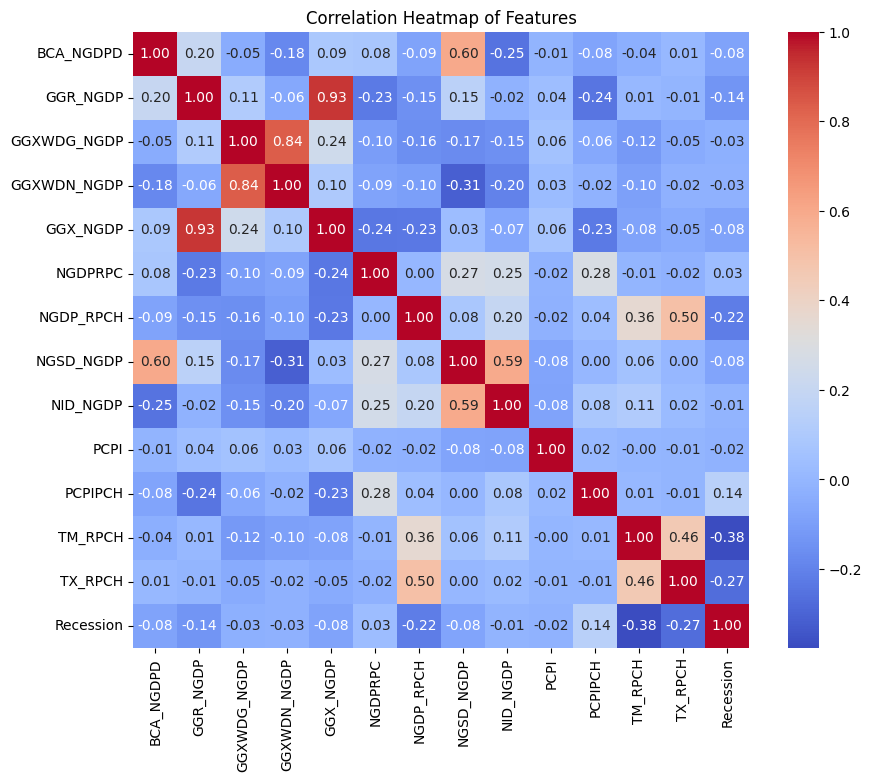

In [60]:
corr = df_filtered.drop(columns=["Country"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

## Prepare Features and Target

In [61]:
X = df_filtered.drop(columns=["Recession", "Country"])
y = df_filtered["Recession"]

# 5. Machine Learning Models

## Global Dataset - Full Features (13 Features)

### Define and Train All Models

In [62]:
def train_all_models(X_train, y_train, X_test, y_test, model_params=None, use_xgb=False, threshold=0.3):
    """
    Train multiple models with SMOTE, evaluate them on train/test sets,
    and return metrics including confusion matrices. Threshold can be set
    for probability-based classifiers.
    """

    # Default hyperparameters
    if model_params is None:
        model_params = {
            'logit': {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs',
                      'max_iter': 5000, 'random_state': 42},
            'rf': {'n_estimators': 200, 'max_depth': 4,
                   'min_samples_leaf': 20, 'min_samples_split': 20,
                   'max_features': 0.3, 'random_state': 42},
            'gb': {'n_estimators': 200, 'learning_rate': 0.03,
                   'max_depth': 2, 'min_samples_leaf': 20,
                   'subsample': 0.6, 'random_state': 42},
            'dt': {'max_depth': 3, 'min_samples_leaf': 30, 'random_state': 42},
            'svm': {'C': 1.0, 'kernel': 'rbf', 'probability': True, 'random_state': 42},
            'xgb': {'n_estimators': 200, 'learning_rate': 0.05,
                    'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 0.6,
                    'reg_alpha': 0.4, 'reg_lambda': 2.0, 'random_state': 42,
                    'use_label_encoder': False, 'eval_metric': 'logloss'}
        }

    # Train models -----------------------------------------------------
    logit = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("logit", LogisticRegression(**model_params['logit']))
    ]).fit(X_train, y_train)

    rf = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(**model_params['rf']))
    ]).fit(X_train, y_train)

    gb = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("gb", GradientBoostingClassifier(**model_params['gb']))
    ]).fit(X_train, y_train)

    dt = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("dt", DecisionTreeClassifier(**model_params['dt']))
    ]).fit(X_train, y_train)

    svm = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("svm", SVC(**model_params['svm']))
    ]).fit(X_train, y_train)

    models = {
        "Logistic Regression": logit,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "Decision Tree": dt,
        "SVM": svm,
    }

    # XGBoost optional
    if use_xgb:
        xgb = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("xgb", XGBClassifier(**model_params['xgb']))
        ]).fit(X_train, y_train)
        models["XGBoost"] = xgb

    # Ensemble (soft voting only)
    ensemble_estimators = [
        ("logit", logit.named_steps["logit"]),
        ("rf", rf.named_steps["rf"]),
        ("gb", gb.named_steps["gb"]),
        ("svm", svm.named_steps["svm"])
    ]
    if use_xgb:
        ensemble_estimators.append(("xgb", xgb.named_steps["xgb"]))

    ensemble = VotingClassifier(estimators=ensemble_estimators, voting="soft")
    ensemble.fit(X_train, y_train)
    models["Ensemble"] = ensemble

    # Compute metrics -----------------------------------------------------------
    results = {}
    confusion_mats = {}

    for name, m in models.items():
        if hasattr(m, "predict_proba"):
            y_pred_train = (m.predict_proba(X_train)[:, 1] >= threshold).astype(int)
            y_pred_test = (m.predict_proba(X_test)[:, 1] >= threshold).astype(int)
        else:
            y_pred_train = m.predict(X_train)
            y_pred_test = m.predict(X_test)

        results[name] = {
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, zero_division=0),
            "Recall": recall_score(y_test, y_pred_test, zero_division=0),
            "F1": f1_score(y_test, y_pred_test, zero_division=0)
        }

        confusion_mats[name] = confusion_matrix(y_test, y_pred_test)

    results_df = pd.DataFrame(results).T
    return models, results_df, confusion_mats



# ============================================================
#             FEATURE IMPORTANCE PLOTTING
# ============================================================
def plot_feature_importance(models, feature_names, title_prefix=""):
    logit = models.get("Logistic Regression")
    rf = models.get("Random Forest")
    gb = models.get("Gradient Boosting")
    dt = models.get("Decision Tree")

    coef = logit.named_steps['logit'].coef_[0]
    logit_importance = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef,
        "Abs_Importance": np.abs(coef)
    }).sort_values("Abs_Importance")

    rf_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf.named_steps['rf'].feature_importances_
    }).sort_values("Importance")

    gb_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb.named_steps['gb'].feature_importances_
    }).sort_values("Importance")

    dt_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": dt.named_steps['dt'].feature_importances_
    }).sort_values("Importance")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes[0, 0].barh(logit_importance["Feature"], logit_importance["Coefficient"])
    axes[0, 0].set_title(f"{title_prefix}Logistic Regression")

    axes[0, 1].barh(rf_importance["Feature"], rf_importance["Importance"])
    axes[0, 1].set_title(f"{title_prefix}Random Forest")

    axes[1, 0].barh(gb_importance["Feature"], gb_importance["Importance"])
    axes[1, 0].set_title(f"{title_prefix}Gradient Boosting")

    axes[1, 1].barh(dt_importance["Feature"], dt_importance["Importance"])
    axes[1, 1].set_title(f"{title_prefix}Decision Tree")

    plt.tight_layout()
    plt.show()


# ============================================================
#             CONFUSION MATRIX DISPLAY FUNCTION (with metrics incl. Accuracy)
# ============================================================
def show_confusion_matrices(confusion_mats, results_df, threshold=0.3):
    """
    Display confusion matrices for all models side by side,
    with Accuracy, Precision, Recall, and F1 shown under each matrix.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    n_models = len(confusion_mats)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for ax, (name, cm) in zip(axes, confusion_mats.items()):
        # Plot directly into the given axis
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", ax=ax, colorbar=False)

        # Extract metrics from results_df
        accuracy = results_df.loc[name, "Test Accuracy"]
        precision = results_df.loc[name, "Precision"]
        recall = results_df.loc[name, "Recall"]
        f1 = results_df.loc[name, "F1"]

        # Add title with model name + metrics
        ax.set_title(
            f"{name}\nAcc={accuracy:.2f}, Prec={precision:.2f}, Rec={recall:.2f}, F1={f1:.2f}",
            fontsize=12
        )

    plt.tight_layout()
    plt.show()


### Train-Test Split

In [63]:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.552846       0.582150   0.545932  0.863071   
Random Forest              0.611280       0.630832   0.572482  0.966805   
Gradient Boosting          0.737297       0.709939   0.659091  0.842324   
Decision Tree              0.783537       0.770791   0.796296  0.713693   
SVM                        0.752541       0.691684   0.632836  0.879668   
Ensemble                   0.666667       0.693712   0.625000  0.933610   

                           F1  
Logistic Regression  0.668810  
Random Forest        0.719136  
Gradient Boosting    0.739526  
Decision Tree        0.752735  
SVM                  0.736111  
Ensemble             0.748752  
[[117 135]
 [ 16 225]]


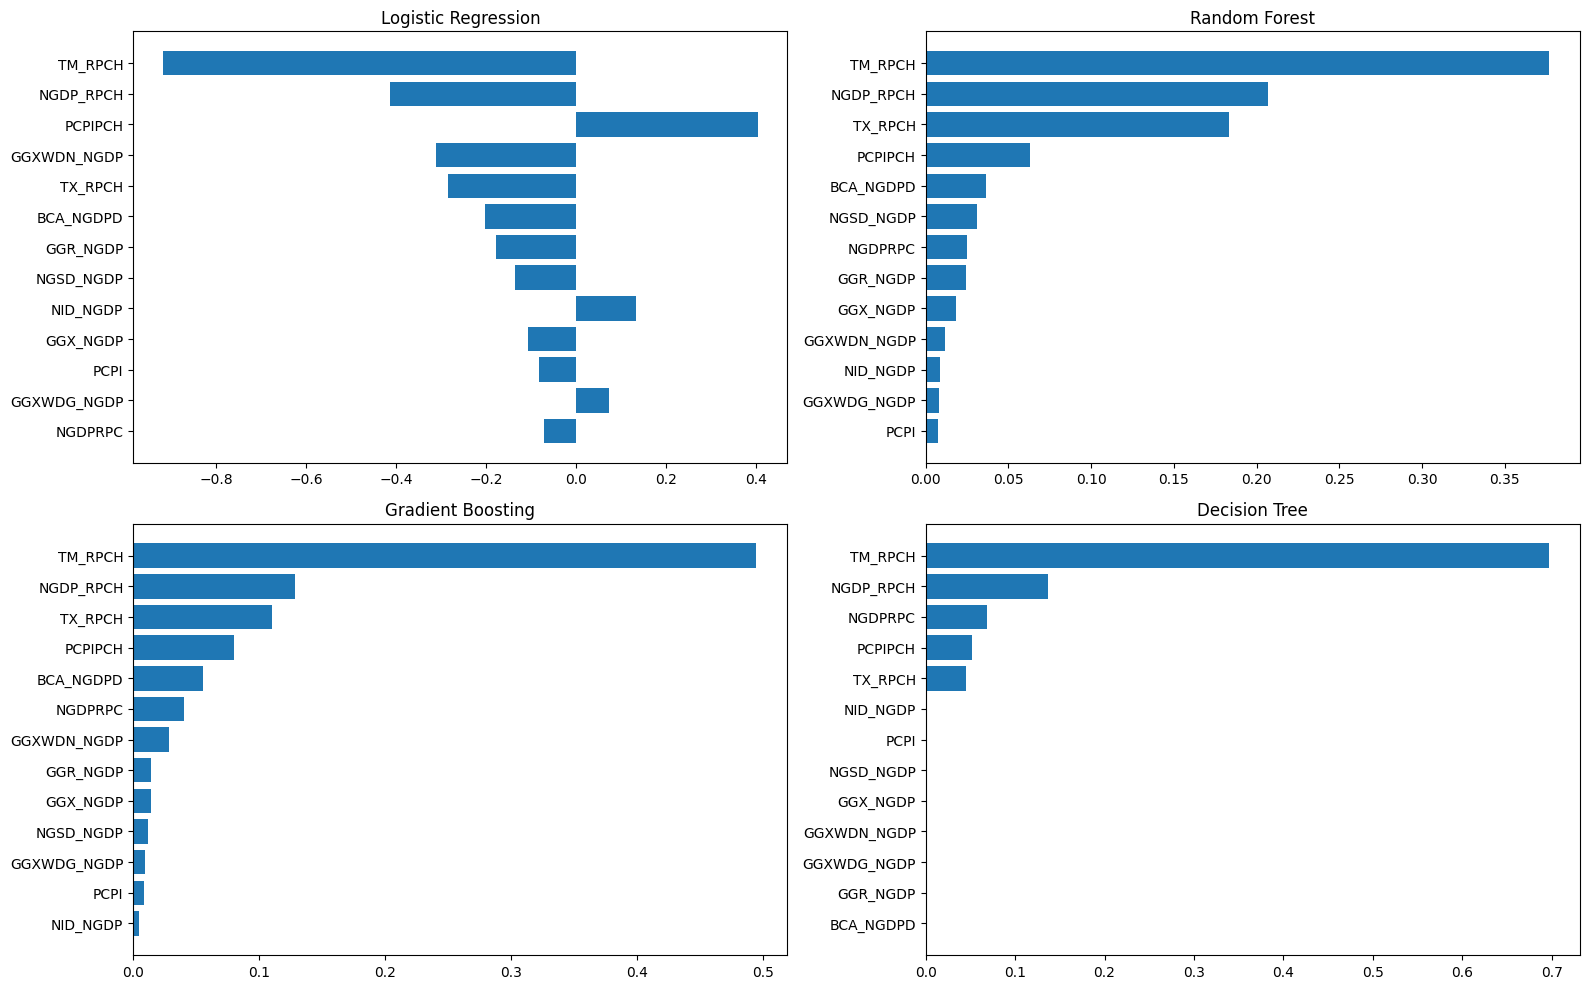

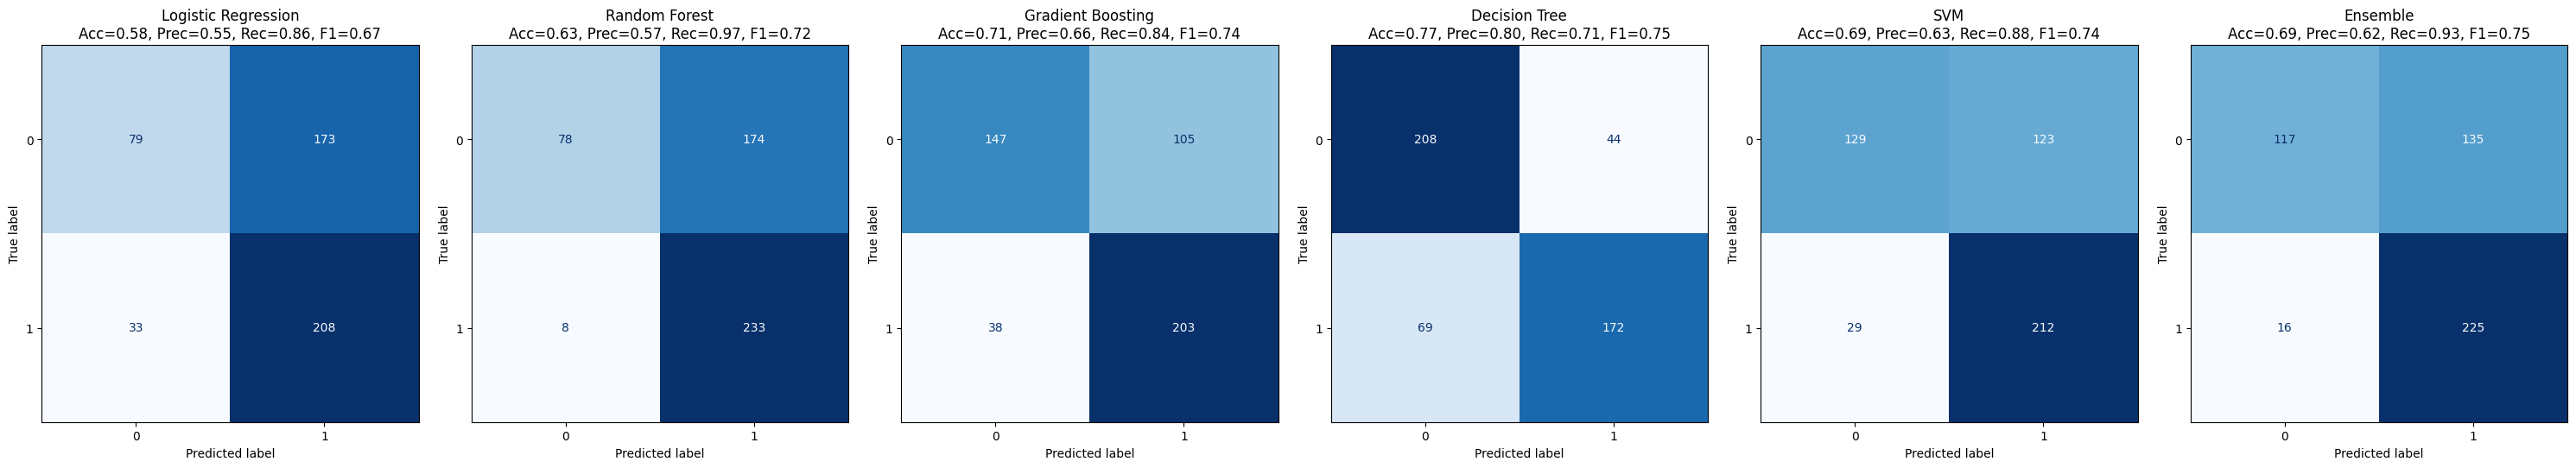

In [64]:
models, summary_df, confusion_mats = train_all_models(X_train, y_train, X_test, y_test)
print(summary_df)
print(confusion_mats["Ensemble"])  # example: confusion matrix for ensemble

plot_feature_importance(models, X_train.columns.tolist())

# Show confusion matrices with metrics underneath
show_confusion_matrices(confusion_mats, summary_df, threshold=0.3)

### Reduced Global Set

In [65]:
selected_features = ['TM_RPCH', 'NGDP_RPCH', 'TX_RPCH', 'PCPIPCH', 'BCA_NGDPD', 'NGDPRPC']
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Unpack all three return values
models_reduced, summary_df_reduced, confusion_mats_reduced = train_all_models(
    X_train_reduced, y_train, X_test_reduced, y_test, threshold=0.3
)

# Show metrics table
print(summary_df_reduced)


                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.498984       0.561866   0.531646  0.871369   
Random Forest              0.588415       0.598377   0.550827  0.966805   
Gradient Boosting          0.733232       0.701826   0.649682  0.846473   
Decision Tree              0.785569       0.772819   0.800000  0.713693   
SVM                        0.737805       0.697769   0.636905  0.887967   
Ensemble                   0.775915       0.728195   0.691756  0.800830   

                           F1  
Logistic Regression  0.660377  
Random Forest        0.701807  
Gradient Boosting    0.735135  
Decision Tree        0.754386  
SVM                  0.741768  
Ensemble             0.742308  


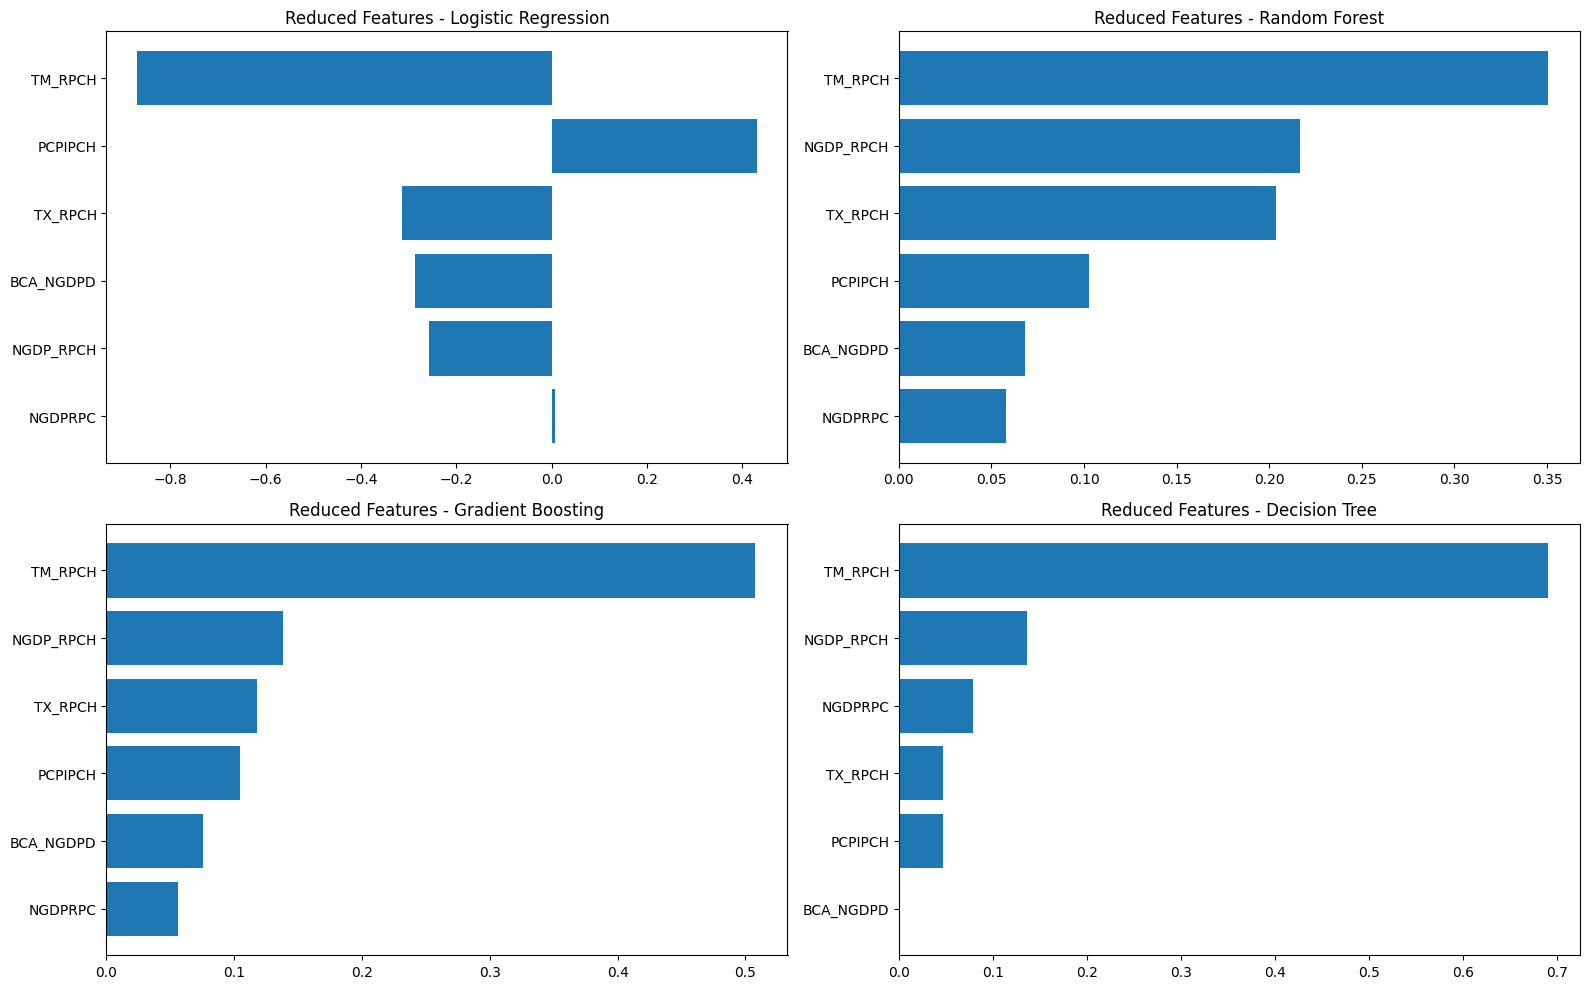

In [66]:
# Plot feature importance
plot_feature_importance(models_reduced, feature_names=selected_features, title_prefix="Reduced Features - ")


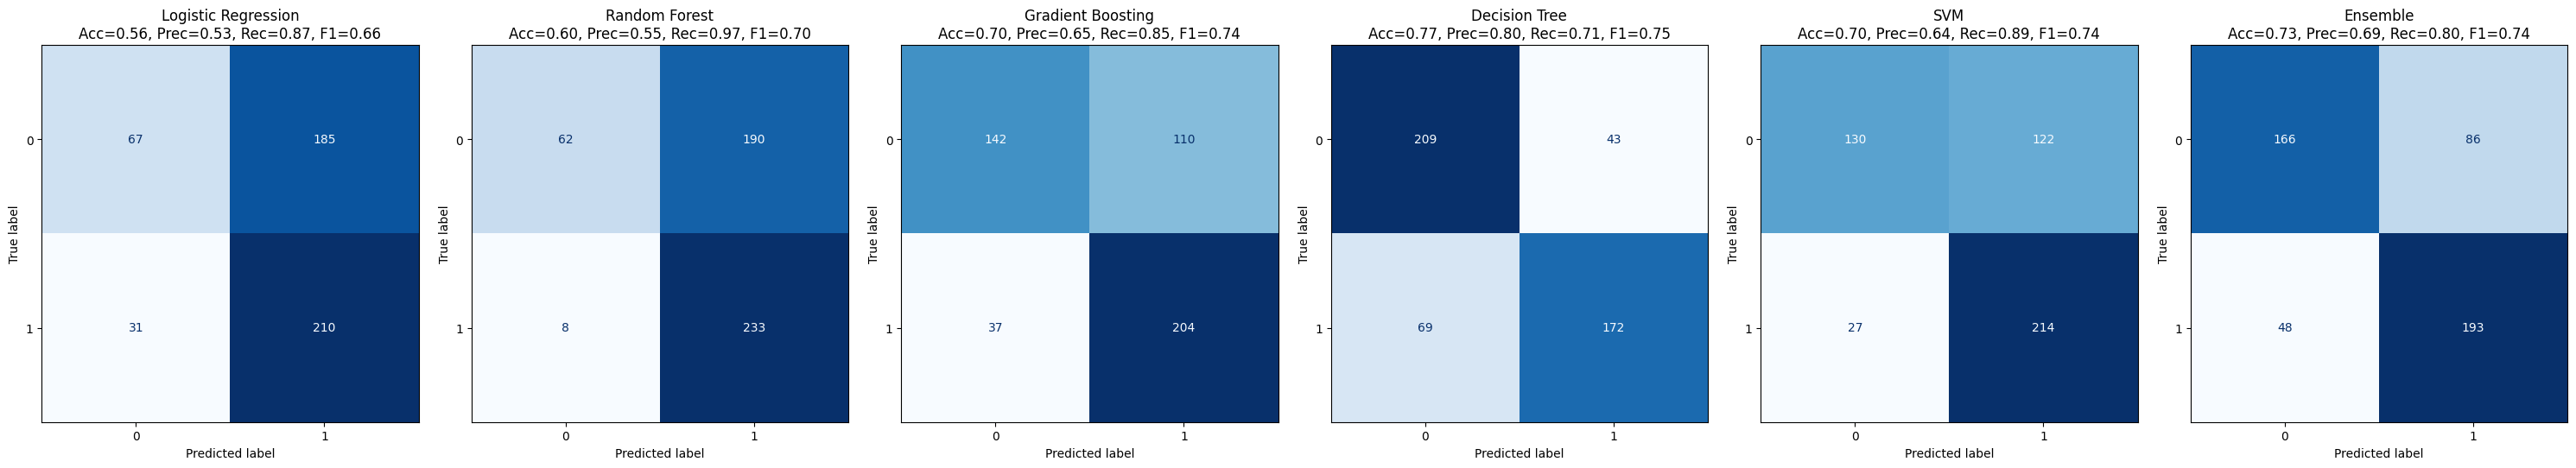

In [67]:

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_reduced, summary_df_reduced, threshold=0.3)

### Split Dataset

In [68]:
# Map countries to continents (same logic as before)
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
        'United_States': 'North_America', 'Canada': 'North_America', 'Mexico': 'North_America',
        'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'Afghanistan': 'Asia',
        'Korea': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia',
        'Germany': 'Europe', 'France': 'Europe', 'United_Kingdom': 'Europe', 'Italy': 'Europe',
        'Spain': 'Europe', 'Russia': 'Europe', 'Turkey': 'Europe', 'Poland': 'Europe',
        'Brazil': 'South_America', 'Argentina': 'South_America', 'Chile': 'South_America',
        'Colombia': 'South_America', 'Peru': 'South_America', 'Venezuela': 'South_America',
        'Australia': 'Oceania', 'New_Zealand': 'Oceania',
        'South_Africa': 'Africa', 'Nigeria': 'Africa', 'Egypt': 'Africa', 'Zimbabwe': 'Africa',
        'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Morocco': 'Africa',
        # Additional countries...
        'Albania': 'Europe', 'Algeria': 'Africa', 'Austria': 'Europe', 'Barbados': 'North_America',
        'Belgium': 'Europe', 'Bolivia': 'South_America', 'Bosnia_and_Herzegovina': 'Europe',
        'Bulgaria': 'Europe', 'Cabo_Verde': 'Africa', 'Costa_Rica': 'North_America',
        'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe',
        'Dominican_Republic': 'North_America', 'Estonia': 'Europe', 'Finland': 'Europe',
        'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
        'Islamic_Republic_of_Iran': 'Asia', 'Israel': 'Asia', 'Jordan': 'Asia',
        'Kazakhstan': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lithuania': 'Europe',
        'Luxembourg': 'Europe', 'Malta': 'Europe', 'Netherlands': 'Europe',
        'North_Macedonia': 'Europe', 'Norway': 'Europe', 'Pakistan': 'Asia',
        'Panama': 'North_America', 'Paraguay': 'South_America', 'Portugal': 'Europe',
        'Romania': 'Europe', 'Saudi_Arabia': 'Asia', 'Serbia': 'Europe', 'Seychelles': 'Africa',
        'Slovak_Republic': 'Europe', 'Slovenia': 'Europe', 'Sweden': 'Europe',
        'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan_Province_of_China': 'Asia',
        'Trinidad_and_Tobago': 'North_America', 'Türkiye': 'Europe', 'Uruguay': 'South_America'
    }
    
    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# --- Add Continent column ---
df_filtered_copy = df_pivot.copy()
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# --- Map continents to economy groups ---
continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_filtered_copy['EconomyGroup'] = df_filtered_copy['Continent'].map(continent_to_economy)

# --- Create Lower and Upper economy DataFrames ---
df_Lower_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Lower_Economies'].drop(columns=['Continent','EconomyGroup'])
df_Upper_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Upper_Economies'].drop(columns=['Continent','EconomyGroup'])

# --- Print summary ---
print("Created economy-specific DataFrames:")
print(f" - Lower_Economies: df_Lower_Economies (rows: {len(df_Lower_Economies)})")
print(f" - Upper_Economies: df_Upper_Economies (rows: {len(df_Upper_Economies)})")


Created economy-specific DataFrames:
 - Lower_Economies: df_Lower_Economies (rows: 863)
 - Upper_Economies: df_Upper_Economies (rows: 1553)


# 6. Economy-Specific Analysis

## Upper Economies - Full Features

                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.608696       0.154341   0.093750  0.931034   
Random Forest              0.726248       0.511254   0.148571  0.896552   
Gradient Boosting          0.799517       0.713826   0.222222  0.827586   
Decision Tree              0.668277       0.745981   0.234043  0.758621   
SVM                        0.796296       0.511254   0.144509  0.862069   
Ensemble                   0.853462       0.845659   0.333333  0.655172   

                           F1  
Logistic Regression  0.170347  
Random Forest        0.254902  
Gradient Boosting    0.350365  
Decision Tree        0.357724  
SVM                  0.247525  
Ensemble             0.441860  


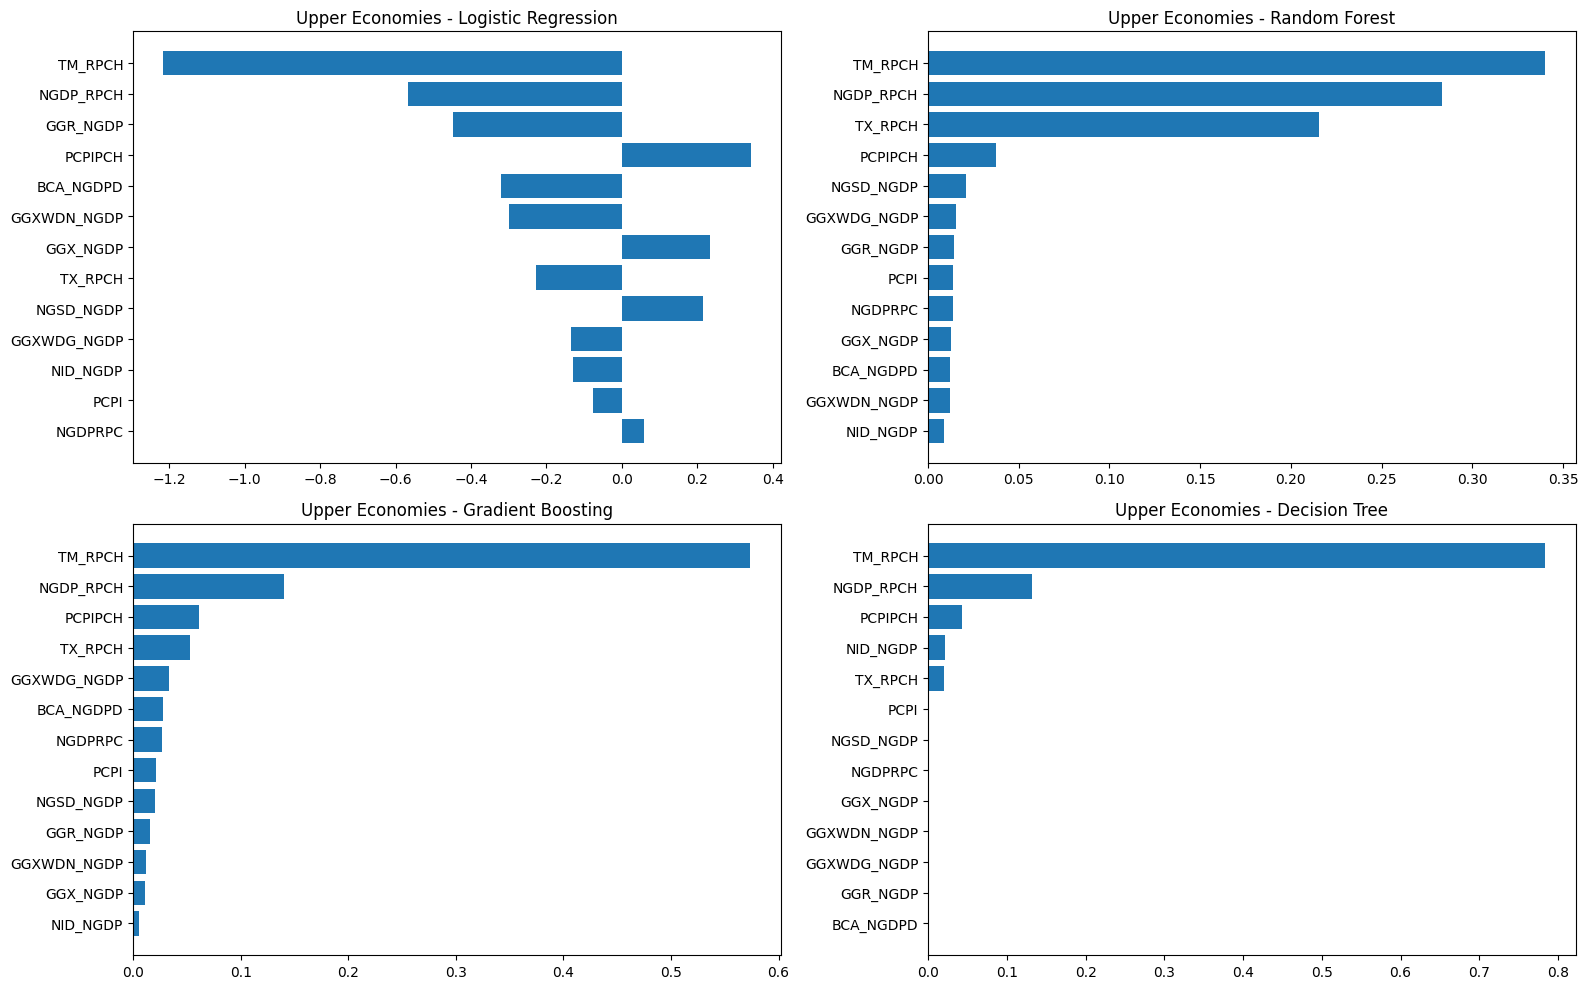

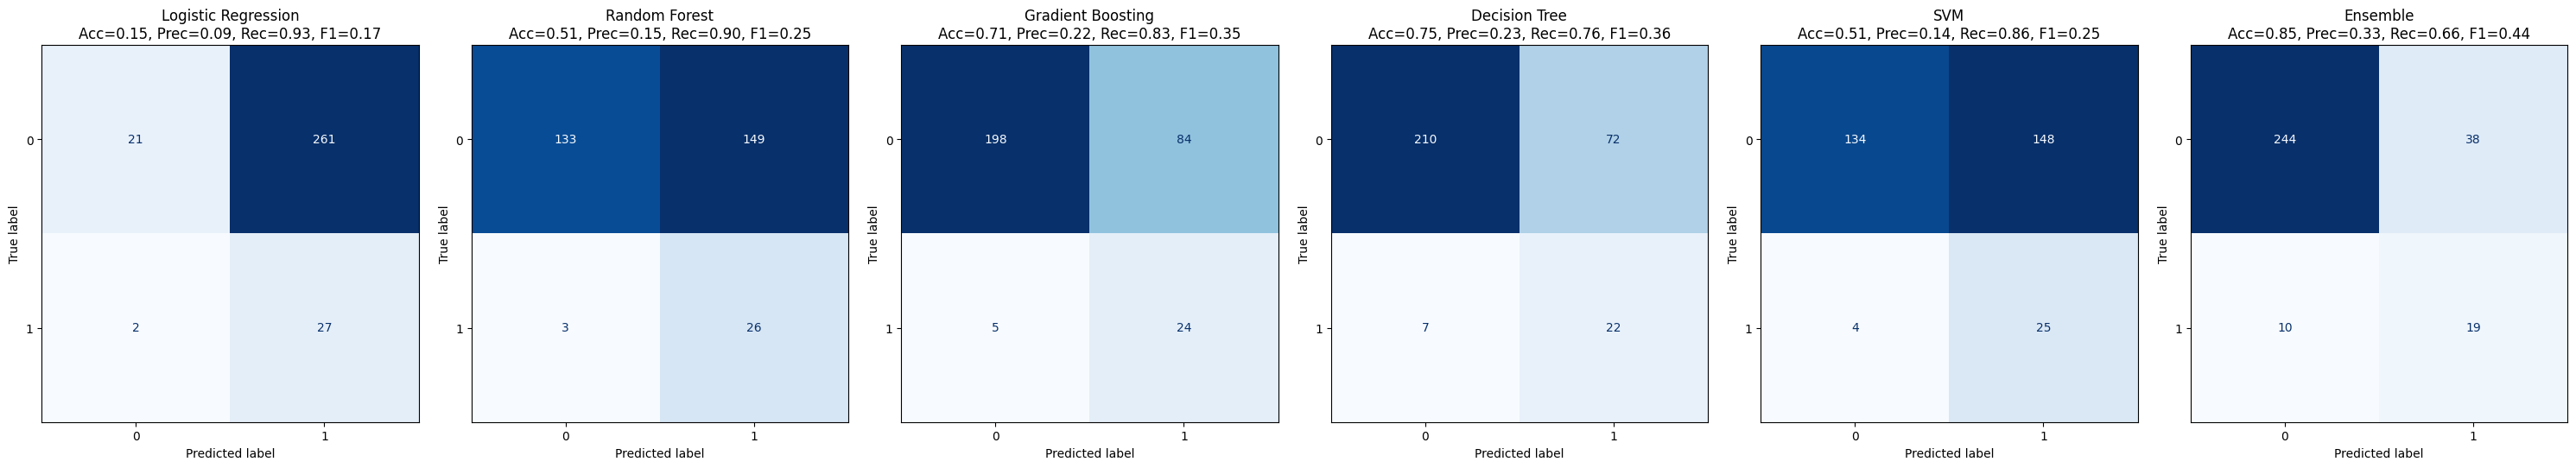

In [69]:
# Prepare data
X = df_Upper_Economies.drop(columns=["Recession", "Country"])
y = df_Upper_Economies["Recession"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train, y_train, X_test, y_test, threshold=0.3
)

# Show metrics table
print(summary_df_upper)

# Plot feature importance
plot_feature_importance(models_upper, X_train.columns.tolist(), title_prefix="Upper Economies - ")

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper, summary_df_upper, threshold=0.3)


## Lower Economies - Full Features

                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.584058       0.184971   0.090323  1.000000   
Random Forest              0.669565       0.260116   0.098592  1.000000   
Gradient Boosting          0.755072       0.560694   0.139535  0.857143   
Decision Tree              0.757971       0.786127   0.232558  0.714286   
SVM                        0.776812       0.479769   0.134615  1.000000   
Ensemble                   0.513043       0.138728   0.085890  1.000000   

                           F1  
Logistic Regression  0.165680  
Random Forest        0.179487  
Gradient Boosting    0.240000  
Decision Tree        0.350877  
SVM                  0.237288  
Ensemble             0.158192  


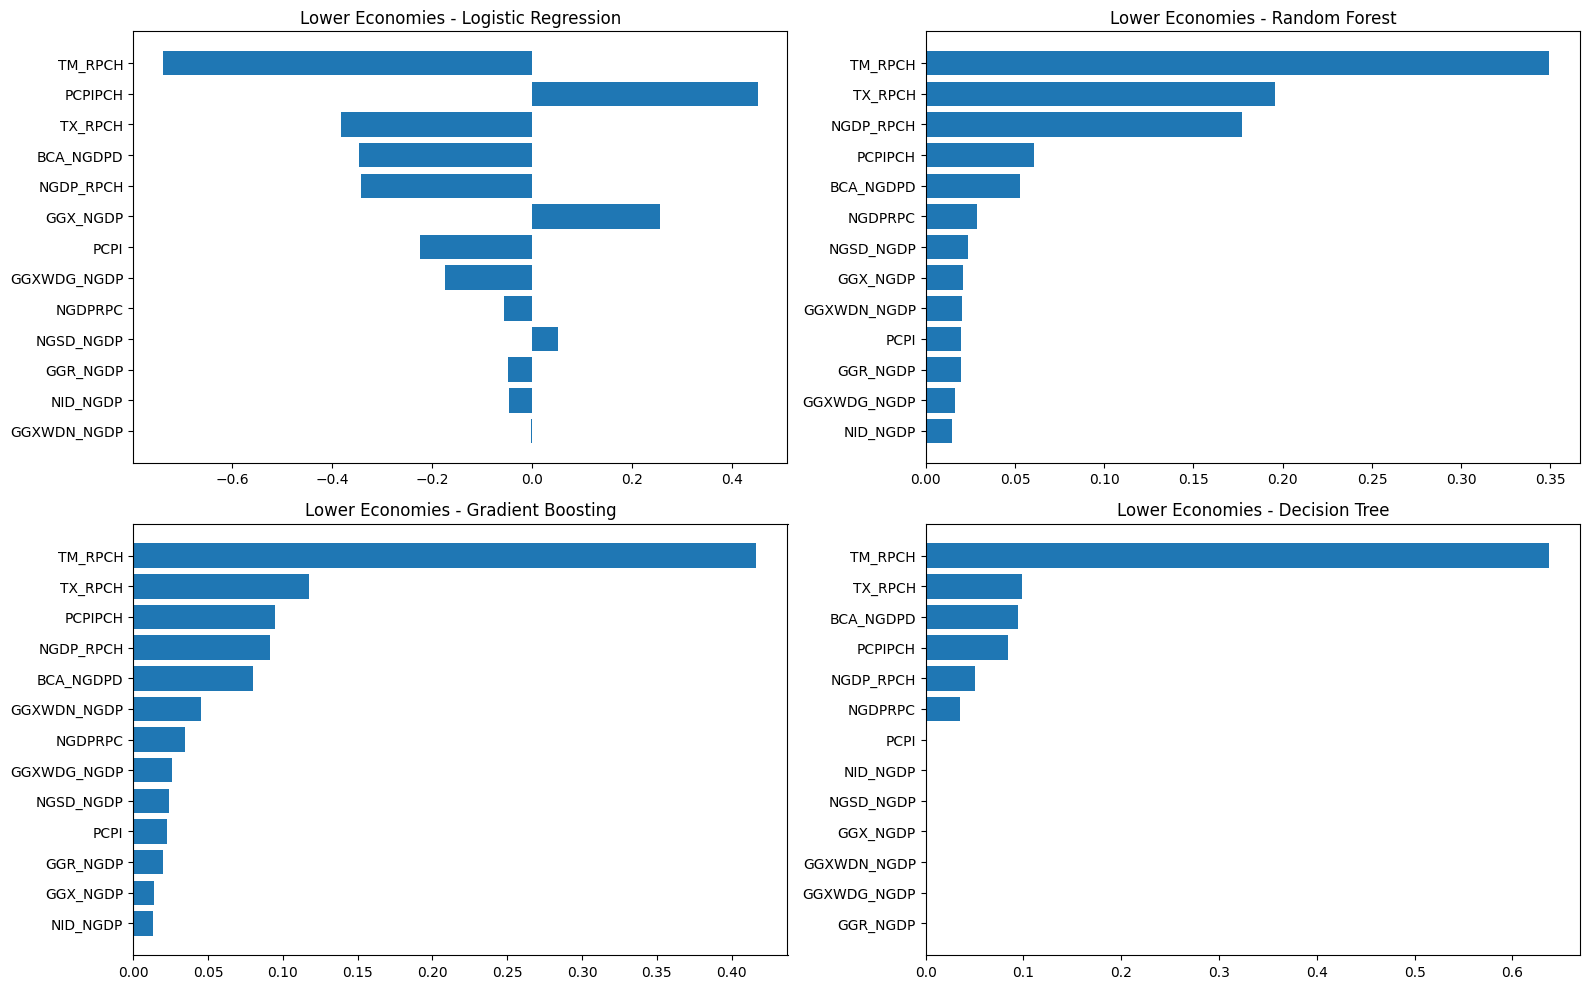

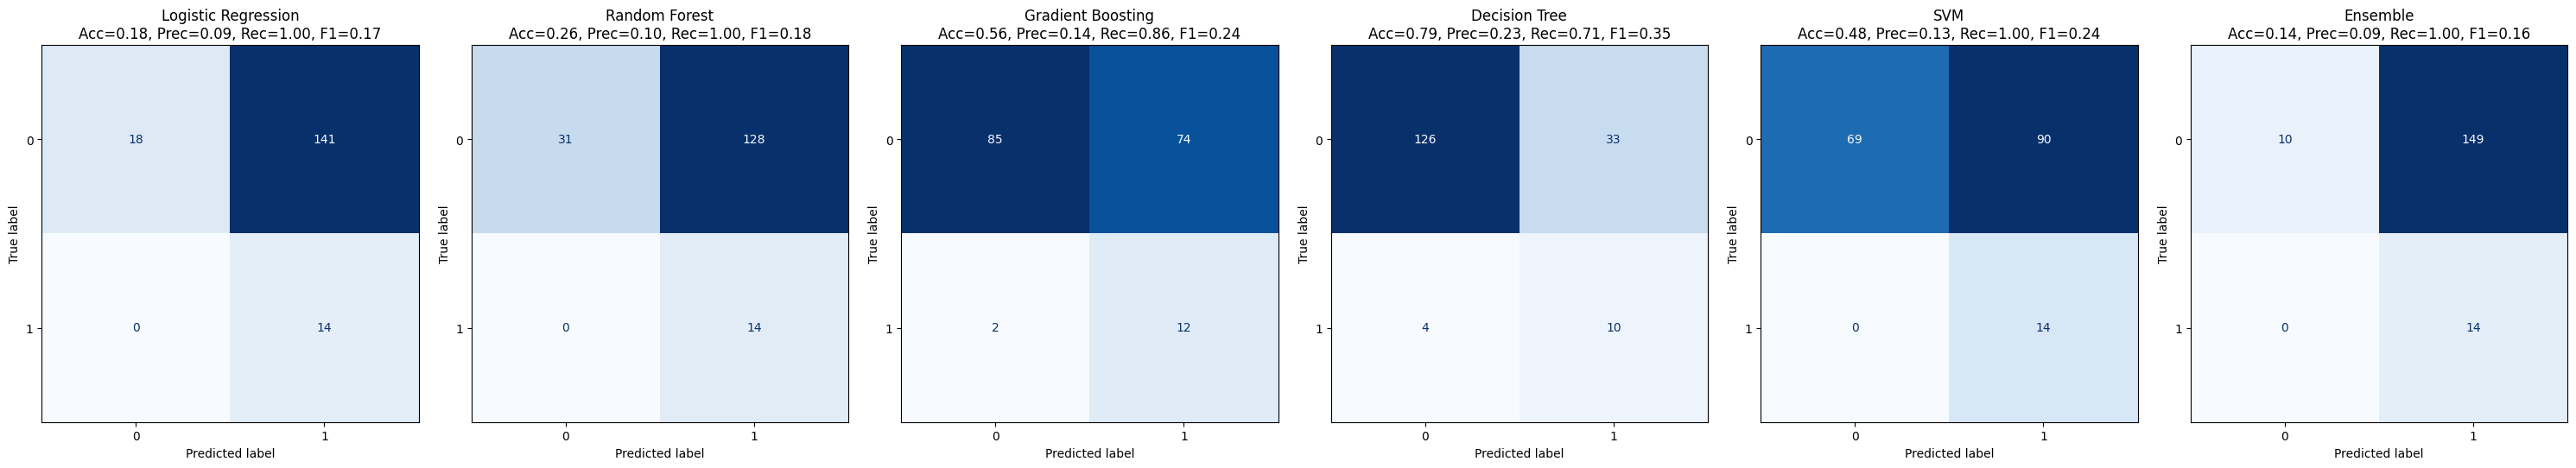

In [70]:
# Prepare data for Lower Economies
X = df_Lower_Economies.drop(columns=["Recession", "Country"])
y = df_Lower_Economies["Recession"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train, y_train, X_test, y_test, threshold=0.3
)

# Show metrics table
print(summary_df_lower)

# Plot feature importance
plot_feature_importance(models_lower, X_train.columns.tolist(), title_prefix="Lower Economies - ")


# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower, summary_df_lower, threshold=0.3)


## Upper Economies - Reduced Features

Upper Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.550725       0.096463   0.088235  0.931034   
Random Forest              0.696457       0.530547   0.149701  0.862069   
Gradient Boosting          0.792271       0.723473   0.228571  0.827586   
Decision Tree              0.798712       0.762058   0.235294  0.689655   
SVM                        0.771337       0.530547   0.149701  0.862069   
Ensemble                   0.835749       0.874598   0.395833  0.655172   

                           F1  
Logistic Regression  0.161194  
Random Forest        0.255102  
Gradient Boosting    0.358209  
Decision Tree        0.350877  
SVM                  0.255102  
Ensemble             0.493506  


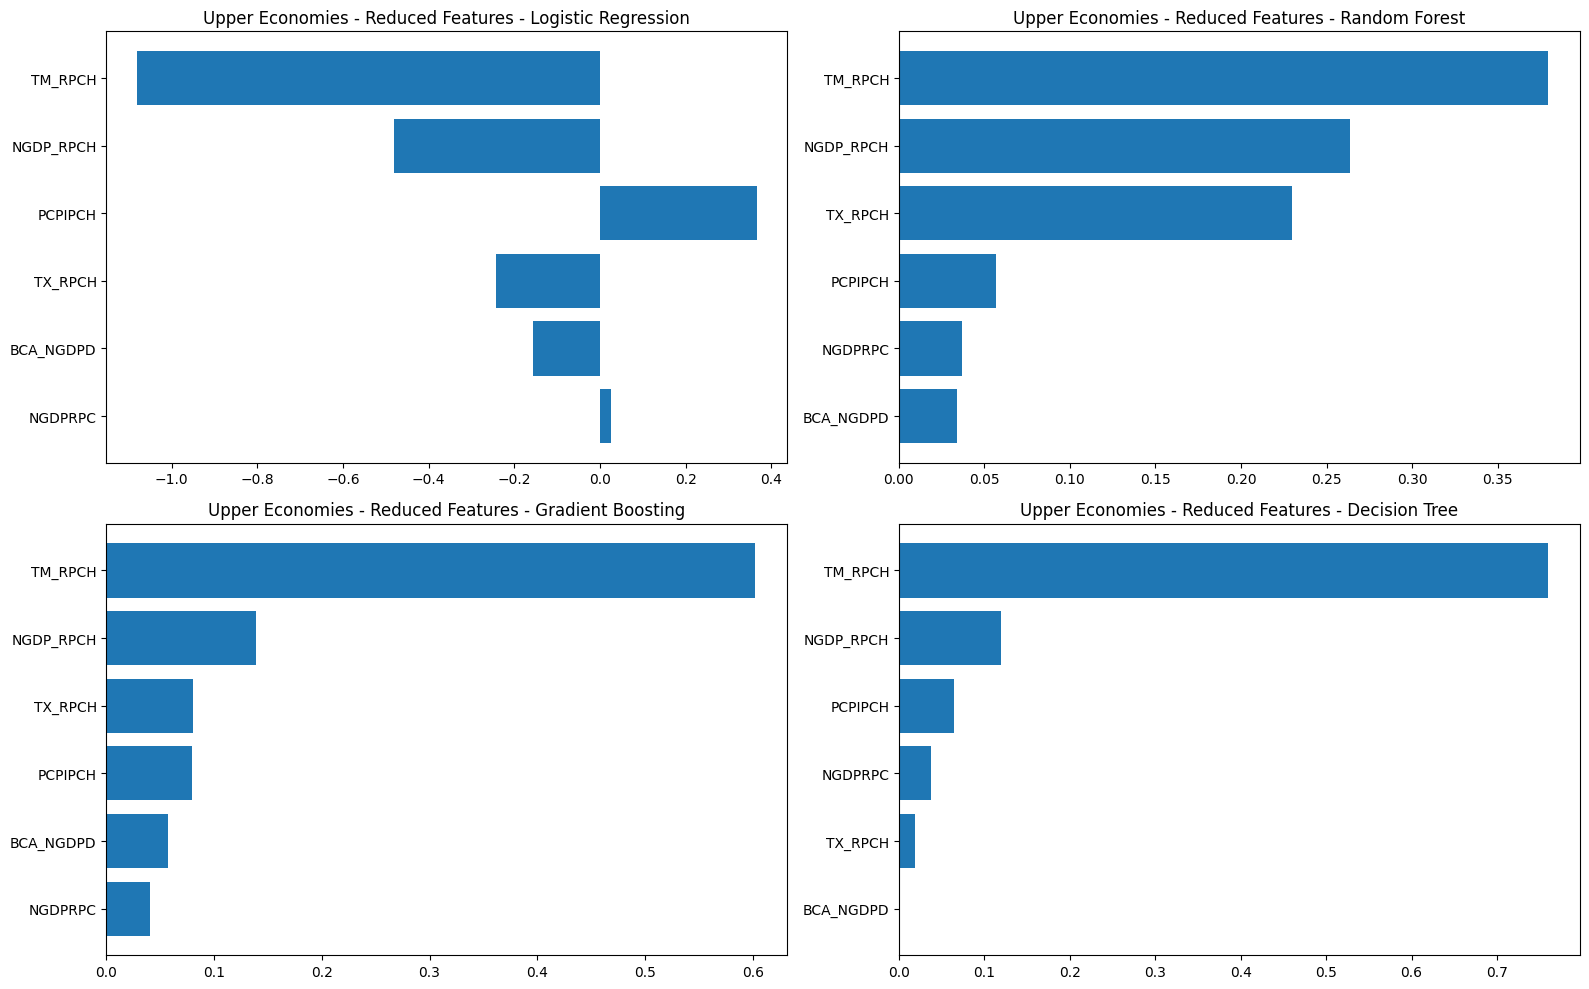

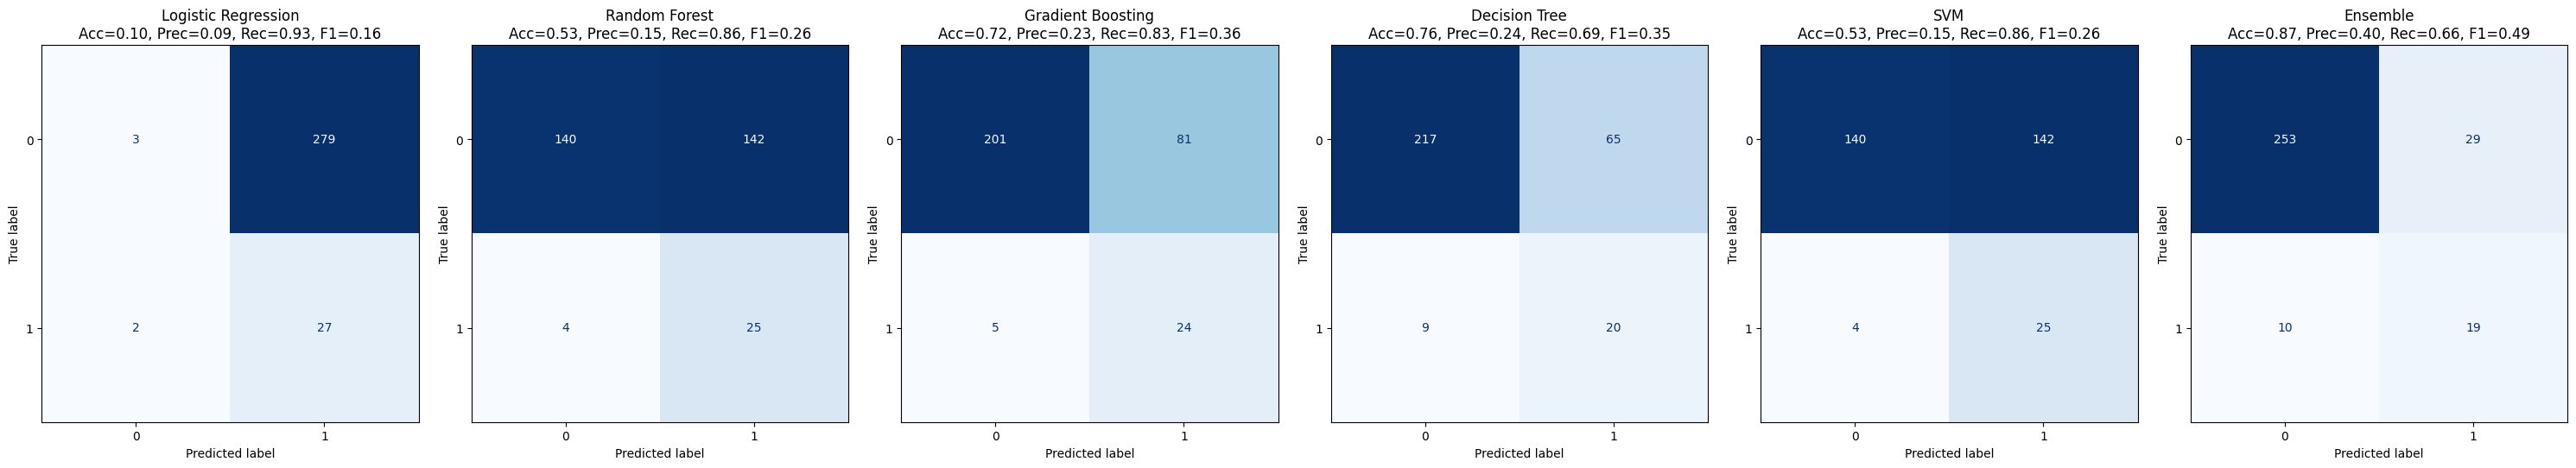

In [71]:
X_upper = df_Upper_Economies[selected_features]
y_upper = df_Upper_Economies["Recession"]

split_index_upper = int(len(X_upper) * 0.8)
X_train_upper = X_upper.iloc[:split_index_upper]
X_test_upper = X_upper.iloc[split_index_upper:]
y_train_upper = y_upper.iloc[:split_index_upper]
y_test_upper = y_upper.iloc[split_index_upper:]

# ✅ Unpack all three return values
models_upper_reduced, summary_df_upper_reduced, confusion_mats_upper_reduced = train_all_models(
    X_train_upper, y_train_upper, X_test_upper, y_test_upper, threshold=0.3
)

print("Upper Economies Accuracy (Reduced Features):")
print(summary_df_upper_reduced)

# Feature importance
plot_feature_importance(models_upper_reduced, feature_names=selected_features, 
                        title_prefix="Upper Economies - Reduced Features - ")

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper_reduced, summary_df_upper_reduced, threshold=0.3)


## Lower Economies - Reduced Features

Lower Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.575362       0.121387   0.084337  1.000000   
Random Forest              0.642029       0.300578   0.103704  1.000000   
Gradient Boosting          0.737681       0.612717   0.155844  0.857143   
Decision Tree              0.757971       0.786127   0.232558  0.714286   
SVM                        0.727536       0.526012   0.130435  0.857143   
Ensemble                   0.689855       0.473988   0.133333  1.000000   

                           F1  
Logistic Regression  0.155556  
Random Forest        0.187919  
Gradient Boosting    0.263736  
Decision Tree        0.350877  
SVM                  0.226415  
Ensemble             0.235294  


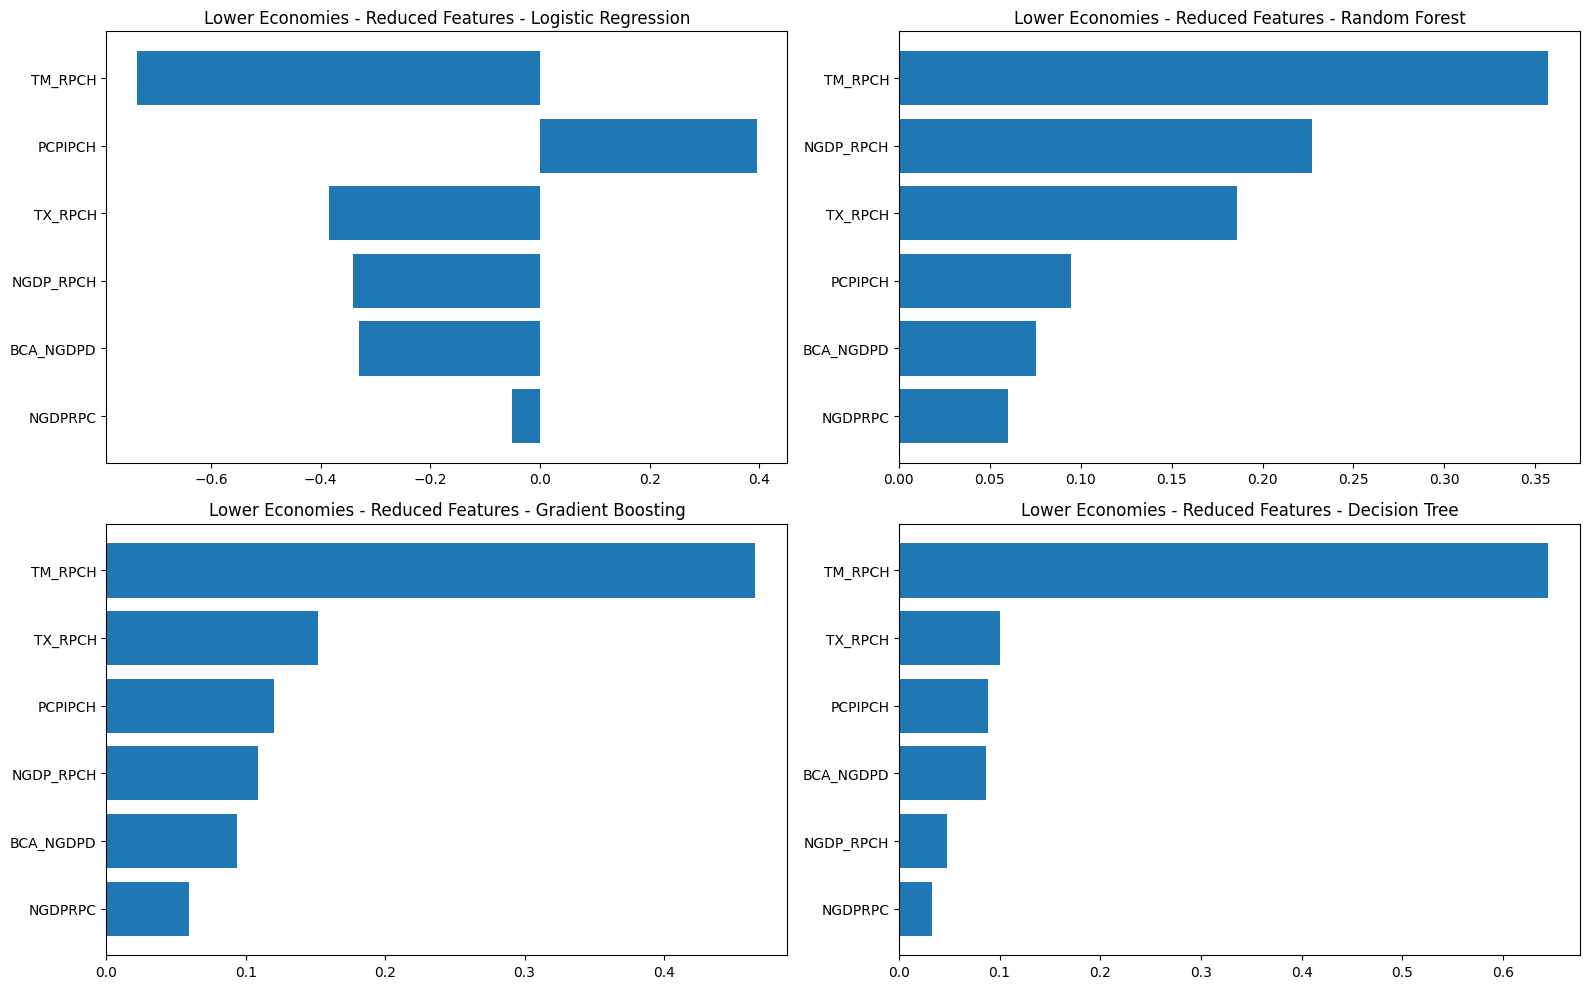

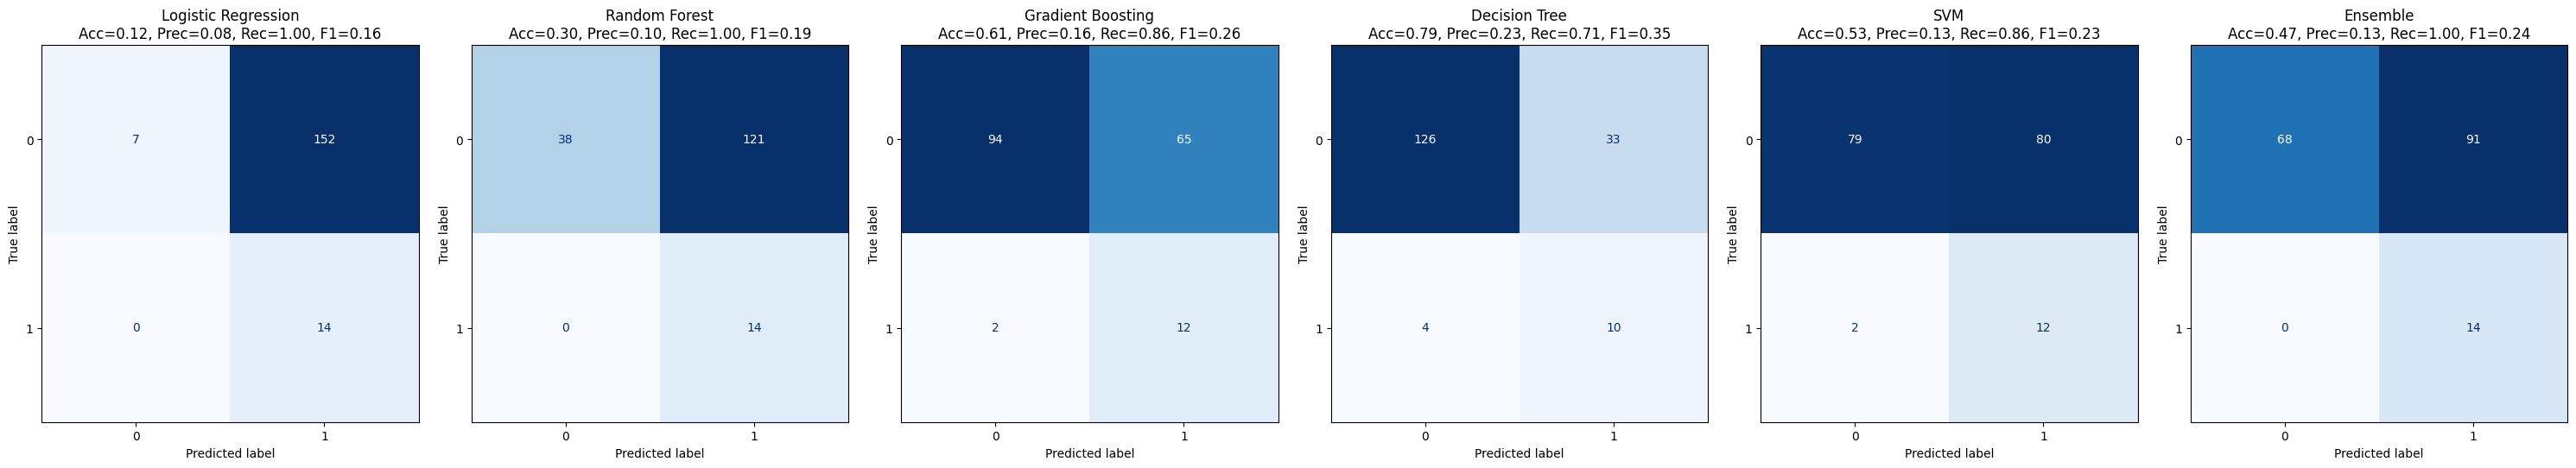

In [72]:
X_lower = df_Lower_Economies[selected_features]
y_lower = df_Lower_Economies["Recession"]

split_index_lower = int(len(X_lower) * 0.8)
X_train_lower = X_lower.iloc[:split_index_lower]
X_test_lower = X_lower.iloc[split_index_lower:]
y_train_lower = y_lower.iloc[:split_index_lower]
y_test_lower = y_lower.iloc[split_index_lower:]

# ✅ Unpack all three return values
models_lower_reduced, summary_df_lower_reduced, confusion_mats_lower_reduced = train_all_models(
    X_train_lower, y_train_lower, X_test_lower, y_test_lower, threshold=0.3
)

print("Lower Economies Accuracy (Reduced Features):")
print(summary_df_lower_reduced)

# Feature importance
plot_feature_importance(models_lower_reduced, feature_names=selected_features, 
                        title_prefix="Lower Economies - Reduced Features - ")


# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower_reduced, summary_df_lower_reduced, threshold=0.3)


# Prediction 2026-2030

In [73]:
df_predict = df_pivot.loc[df_pivot.index > 2025]
df_predict_original = df_predict.copy()
df_predict = df_predict.drop(columns=["Recession", "Country"])

df_predict_original['Continent'] = df_predict_original['Country'].astype(str).apply(country_to_continent)

continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_predict_original['EconomyGroup'] = df_predict_original['Continent'].map(continent_to_economy)

df_predict_lower = df_predict_original[df_predict_original['EconomyGroup'] == 'Lower_Economies']

df_predict_upper = df_predict_original[df_predict_original['EconomyGroup'] == 'Upper_Economies']

print("Created economy-specific prediction DataFrames from df_predict_original:")
print(f" - Lower_Economies predictions: {len(df_predict_lower)} rows")
print(f" - Upper_Economies predictions: {len(df_predict_upper)} rows")

Created economy-specific prediction DataFrames from df_predict_original:
 - Lower_Economies predictions: 126 rows
 - Upper_Economies predictions: 215 rows


In [74]:
# ============================================================
#                  PREDICTION FUNCTION
# ============================================================
def make_predictions(models, df_predict, use_threshold=True, threshold=0.30):
    """
    Return predictions from every model in one dataframe.
    """
    predictions = {}
    for name, model in models.items():
        if use_threshold and hasattr(model, 'predict_proba'):
            proba = model.predict_proba(df_predict)[:, 1]
            predictions[name] = (proba >= threshold).astype(int)
        else:
            predictions[name] = model.predict(df_predict)
    return pd.DataFrame(predictions, index=df_predict.index)

def plot_recession_counts_per_model(df_with_country, title):
    """
    Grouped bar plot per year per model:
    - X: Year
    - Bars: In recession vs Not in recession
    - Facets: One subplot per model
    Expects df_with_country with columns: ['Year','Country', <model columns...>] where model columns are 0/1.
    """
    # Melt to long format: one row per (Year, Country, Model, Prediction)
    df_long = df_with_country.melt(
        id_vars=['Year','Country'],
        var_name='Model',
        value_name='Prediction'
    )

    # Count per (Year, Model, Prediction)
    counts = (
        df_long.groupby(['Year','Model','Prediction'])
               .size()
               .reset_index(name='Count')
    )

    # Pivot to have columns: 'Not in recession' (0) and 'In recession' (1)
    counts_pivot = (
        counts.pivot(index=['Year','Model'], columns='Prediction', values='Count')
              .fillna(0)
              .rename(columns={0: 'Not in recession', 1: 'In recession'})
    ).reset_index()

    # Get model list and create subplots
    models = counts_pivot['Model'].unique()
    n_models = len(models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.8 * n_rows), sharex=False, sharey=True)
    axes = axes.flatten()

    for i, model in enumerate(models):
        ax = axes[i]
        mdf = counts_pivot[counts_pivot['Model'] == model].set_index('Year')[['Not in recession','In recession']]
        mdf.plot(kind='bar', ax=ax)
        ax.set_title(model)
        ax.set_ylabel('Number of countries')
        ax.set_xlabel('Year')
        ax.legend(title='Status')

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()


In [75]:
df_predict_upper_copy = df_predict_upper.copy()
df_predict_lower_copy = df_predict_lower.copy()
df_predict_upper_copy.drop(columns=['Continent', 'EconomyGroup', 'Country'], inplace=True)
df_predict_lower_copy.drop(columns=['Continent', 'EconomyGroup', 'Country'], inplace=True)

In [84]:
# Reset index once for reuse (assumes Year is the index in df_predict_original)
df_predict_original_reset = df_predict_original.reset_index()
df_predict_upper = df_predict_upper.reset_index()
df_predict_lower = df_predict_lower.reset_index()

   Year  Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026   Canada                    1              0                  0   
1  2026    Korea                    1              1                  1   
2  2026    Chile                    1              1                  1   
3  2026   Sweden                    1              0                  0   
4  2026  Albania                    1              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              0    0         1  
2              0    0         1  
3              0    1         0  
4              0    0         0  


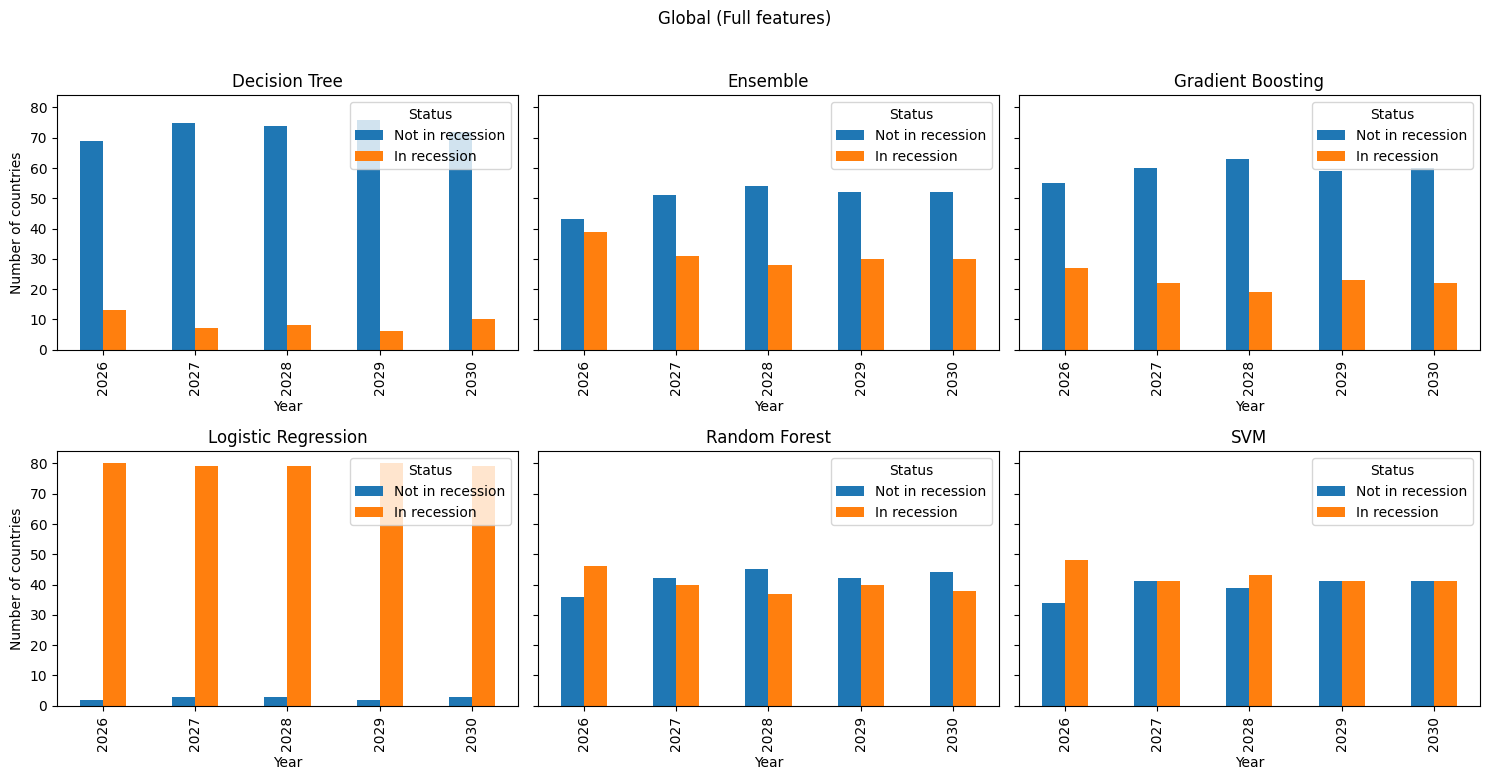

In [77]:
# ============================================================
# Global (all countries, full feature set)
# ============================================================
predictions = make_predictions(models, df_predict, threshold=0.30)
predictions_global_features_with_country = pd.concat(
    [df_predict_original_reset[['Year', 'Country']], predictions.reset_index(drop=True)],
    axis=1
)
print(predictions_global_features_with_country.head())
plot_recession_counts_per_model(predictions_global_features_with_country, "Global (Full features)")


   Year  Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026   Canada                    1              0                  0   
1  2026    Korea                    1              0                  0   
2  2026    Chile                    1              1                  1   
3  2026   Sweden                    1              0                  0   
4  2026  Albania                    1              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              0    1         0  
2              0    0         0  
3              0    0         0  
4              0    0         0  


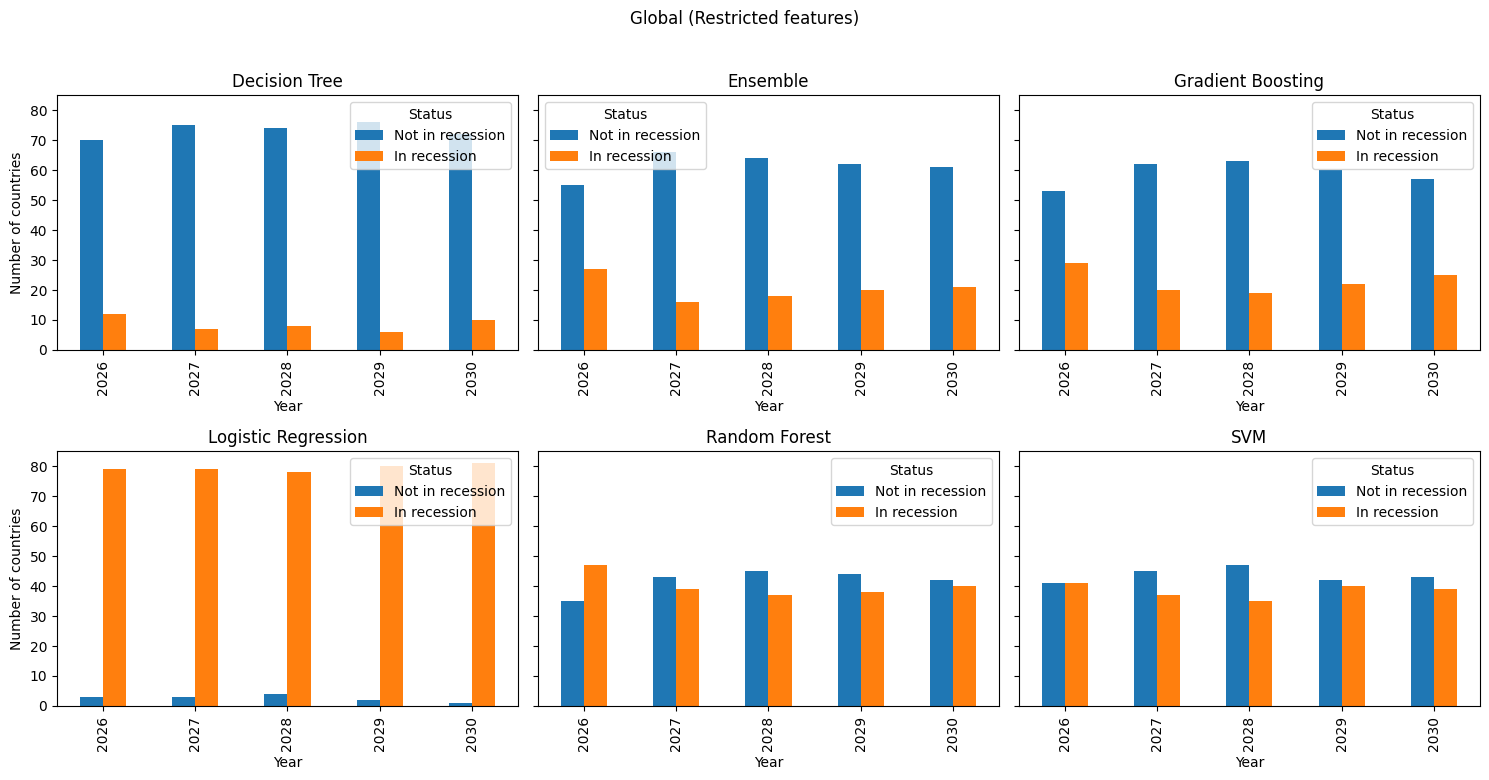

In [78]:
# ============================================================
# Global Restricted (all countries, restricted feature set)
# ============================================================
df_predict_restricted = df_predict[selected_features]
predictions_restricted_features = make_predictions(models_reduced, df_predict_restricted, threshold=0.3)
predictions_global_restricted_features_with_country = pd.concat(
    [df_predict_original_reset[['Year', 'Country']], predictions_restricted_features.reset_index(drop=True)],
    axis=1
)
print(predictions_global_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_global_restricted_features_with_country, "Global (Restricted features)")


   Year   Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026    Canada                    1              0                  0   
1  2026    Sweden                    1              0                  0   
2  2026   Albania                    1              1                  0   
3  2026   Estonia                    1              1                  1   
4  2026  Portugal                    1              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              0    1         0  
2              0    0         0  
3              1    1         1  
4              0    0         0  


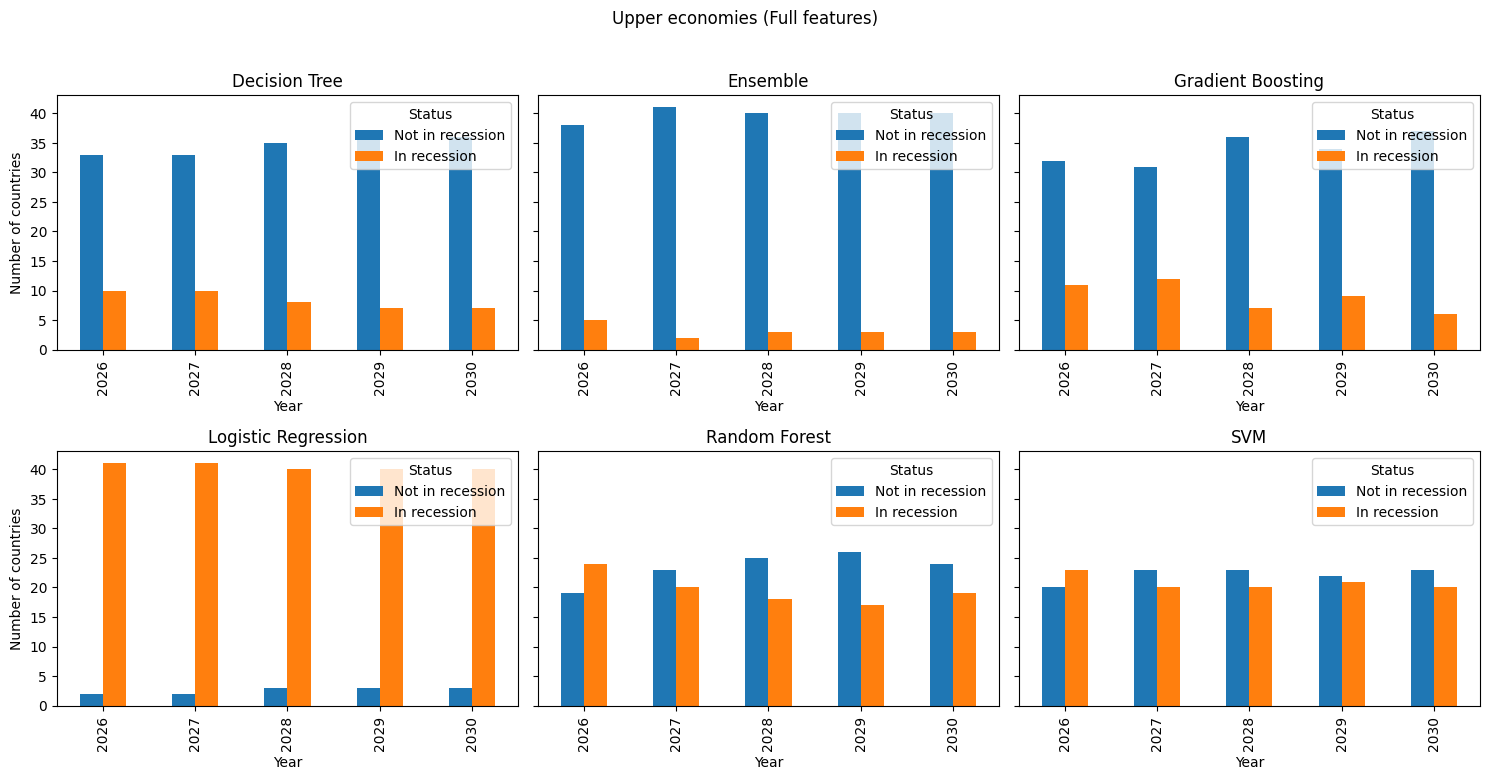

In [88]:

# ============================================================
# Upper Economies (full feature set)
# ============================================================
df_predict_upper_reset = df_predict_upper_copy.reset_index(drop=True)

X_predict_upper = df_predict_upper_reset.drop(columns=["Recession", "Country"], errors="ignore")
predictions_upper_features = make_predictions(models_upper, X_predict_upper, threshold=0.3)

predictions_upper_features_with_country = pd.concat(
    [df_predict_upper[["Year", "Country"]], predictions_upper_features.reset_index(drop=True)],
    axis=1
)

print(predictions_upper_features_with_country.head())
plot_recession_counts_per_model(predictions_upper_features_with_country, "Upper economies (Full features)")




   Year                   Country  Logistic Regression  Random Forest  \
0  2026                     Korea                    1              1   
1  2026                     Chile                    1              1   
2  2026  Islamic_Republic_of_Iran                    1              1   
3  2026                    Israel                    1              0   
4  2026                  Ethiopia                    1              1   

   Gradient Boosting  Decision Tree  SVM  Ensemble  
0                  1              0    1         1  
1                  1              0    0         1  
2                  1              1    1         1  
3                  0              0    0         1  
4                  1              1    1         1  


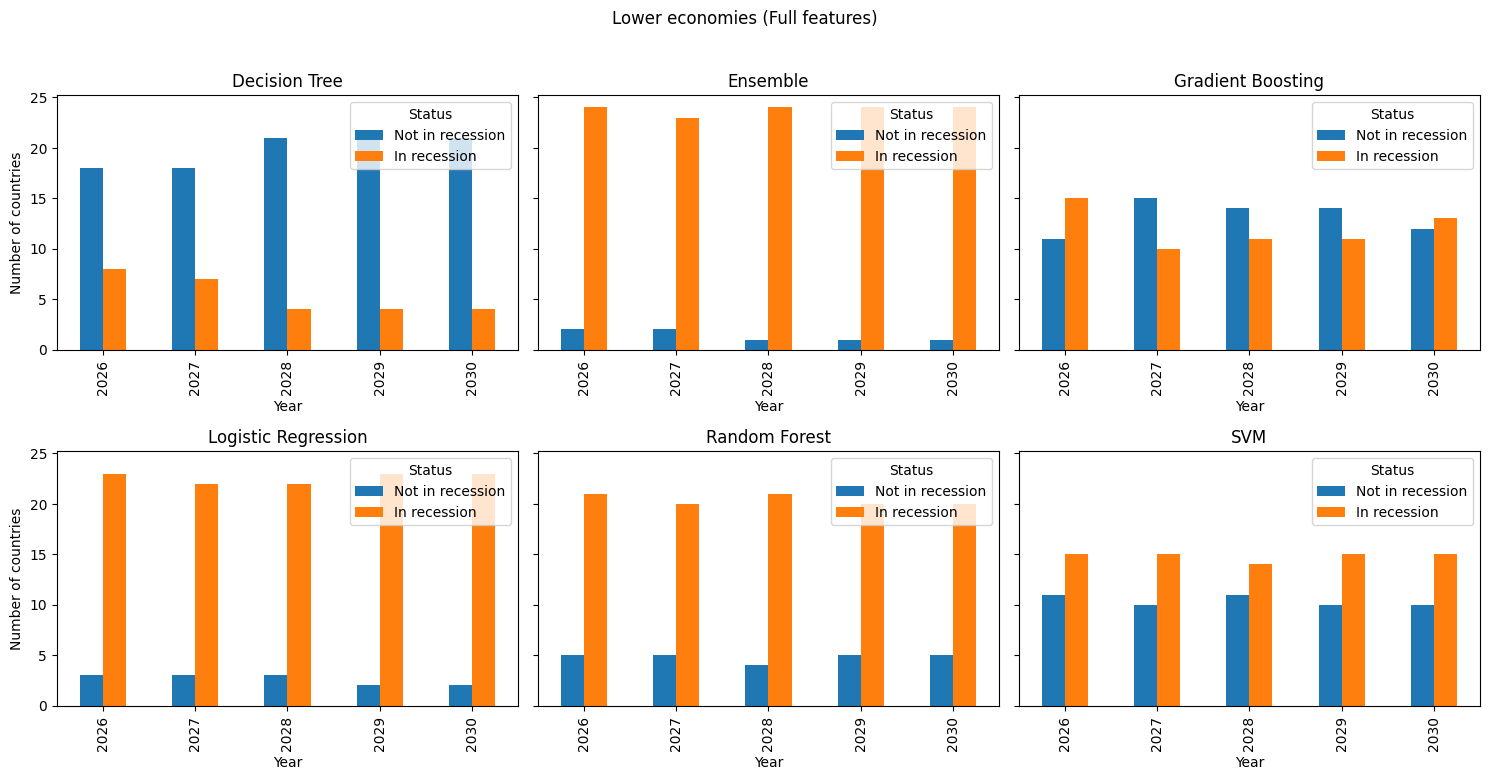

In [89]:
# ============================================================
# Lower Economies (full feature set)
# ============================================================
df_predict_lower_reset = df_predict_lower_copy.reset_index(drop=True)

X_predict_lower = df_predict_lower_reset.drop(columns=["Recession", "Country"], errors="ignore")
predictions_lower_features = make_predictions(models_lower, X_predict_lower, threshold=0.3)

predictions_lower_features_with_country = pd.concat(
    [df_predict_lower[["Year", "Country"]], predictions_lower_features.reset_index(drop=True)],
    axis=1
)

print(predictions_lower_features_with_country.head())
plot_recession_counts_per_model(predictions_lower_features_with_country, "Lower economies (Full features)")


   Year   Country  Logistic Regression  Random Forest  Gradient Boosting  \
0  2026    Canada                    1              0                  0   
1  2026    Sweden                    1              0                  0   
2  2026   Albania                    1              0                  0   
3  2026   Estonia                    1              1                  1   
4  2026  Portugal                    1              0                  0   

   Decision Tree  SVM  Ensemble  
0              0    0         0  
1              0    1         0  
2              0    0         0  
3              0    1         1  
4              0    1         0  


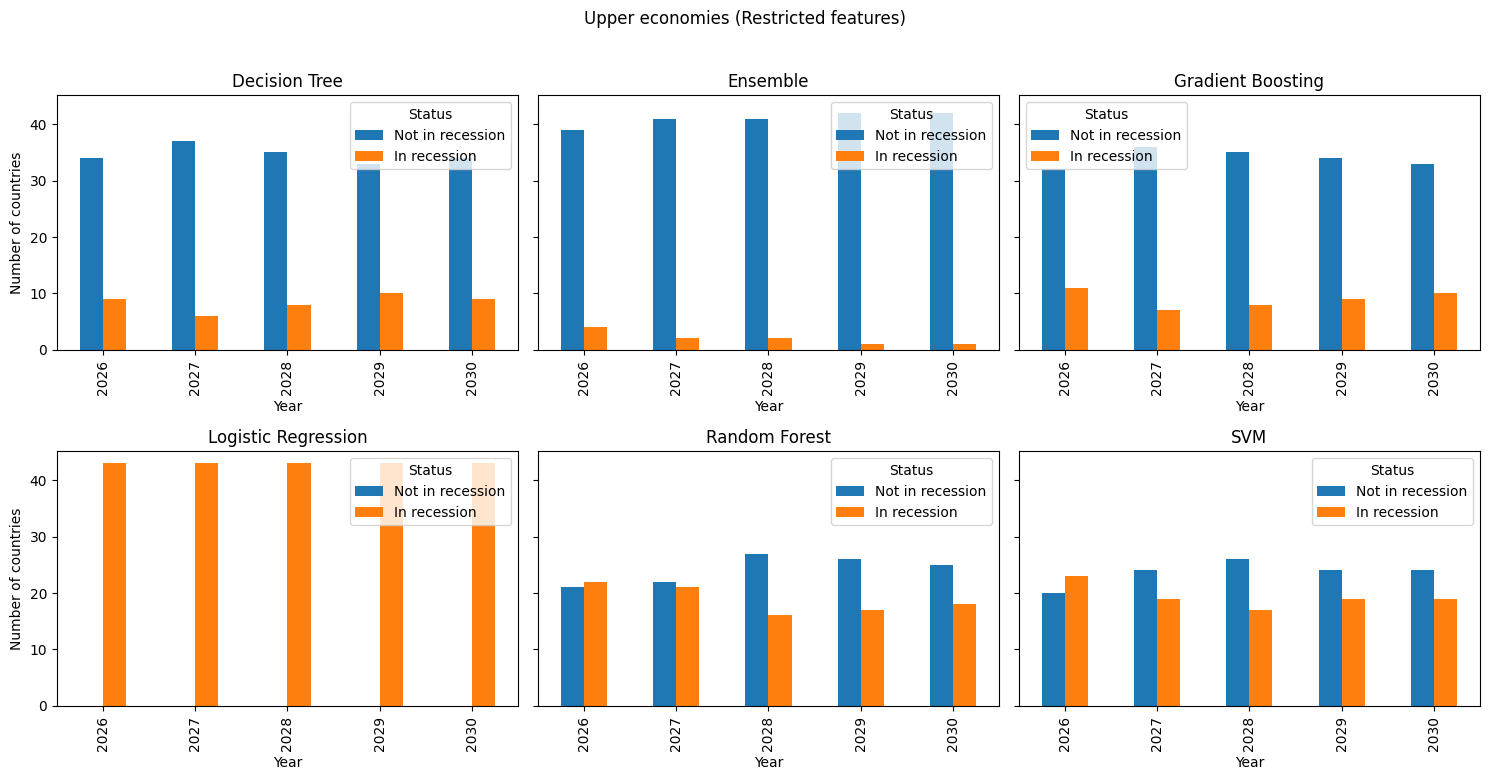

In [90]:
# ============================================================
# Upper Economies (restricted feature set)
# ============================================================
X_predict_upper_reduced = df_predict_upper[selected_features]
df_predict_upper_reset = df_predict_upper_copy.reset_index(drop=True)

X_predict_upper_reduced = df_predict_upper_reset[selected_features]
predictions_upper_restricted_features = make_predictions(models_upper_reduced, X_predict_upper_reduced, threshold=0.3)

predictions_upper_restricted_features_with_country = pd.concat(
    [df_predict_upper[["Year", "Country"]], predictions_upper_restricted_features.reset_index(drop=True)],
    axis=1
)

print(predictions_upper_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_upper_restricted_features_with_country, "Upper economies (Restricted features)")



   Year                   Country  Logistic Regression  Random Forest  \
0  2026                     Korea                    1              1   
1  2026                     Chile                    1              1   
2  2026  Islamic_Republic_of_Iran                    1              1   
3  2026                    Israel                    1              1   
4  2026                  Ethiopia                    1              1   

   Gradient Boosting  Decision Tree  SVM  Ensemble  
0                  0              0    1         1  
1                  0              0    1         1  
2                  1              1    1         1  
3                  0              0    0         0  
4                  1              1    1         1  


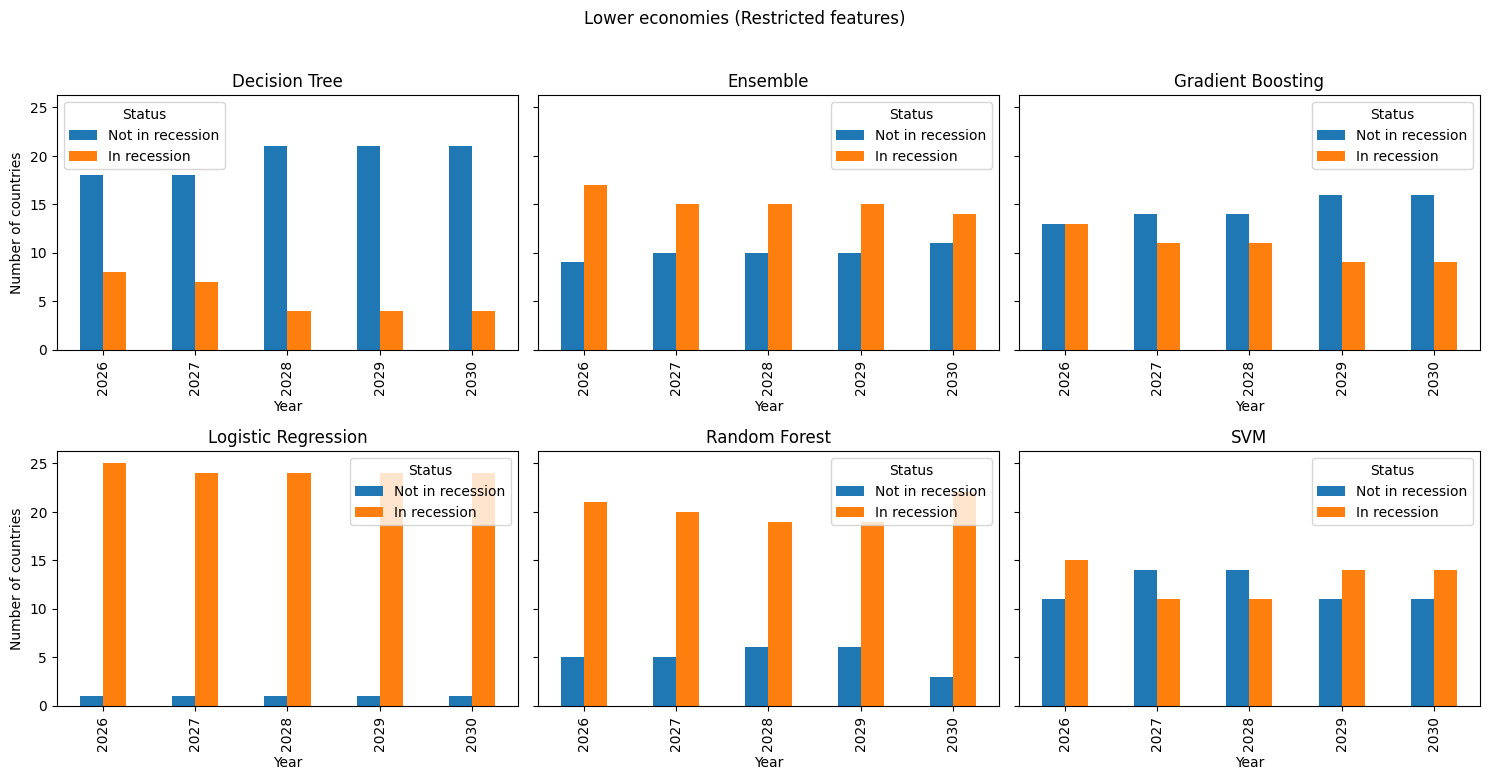

In [91]:
# ============================================================
# Lower Economies (restricted feature set)
# ============================================================
X_predict_lower_reduced = df_predict_lower[selected_features]
df_predict_lower_reset = df_predict_lower_copy.reset_index(drop=True)
X_predict_lower_reduced = df_predict_lower_reset[selected_features]
predictions_lower_restricted_features = make_predictions(models_lower_reduced, X_predict_lower_reduced, threshold=0.3)

predictions_lower_restricted_features_with_country = pd.concat(
    [df_predict_lower[["Year", "Country"]], predictions_lower_restricted_features.reset_index(drop=True)],
    axis=1
)

print(predictions_lower_restricted_features_with_country.head())
plot_recession_counts_per_model(predictions_lower_restricted_features_with_country, "Lower economies (Restricted features)")